In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
import seaborn as sns 
import scanpy as sc
import scipy as sp
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.18.5 scipy==1.5.0 pandas==1.0.5 scikit-learn==0.22.1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.6.1 leidenalg==0.8.1


Data is derived from ...
https://www.nature.com/articles/ncomms14049

Peripheral blood mononuclear cells (PBMCs) -- human

Normally, we would load the raw data as follows

In [3]:
# adata = sc.read_10x_mtx(
#    'data/from10x/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
#    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
#    cache=True) 

In [5]:
adata = sc.read("data/from10x/pbmc10x_full.h5ad")

In [6]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

### Meet annData

![title](img/anndata.svg)

### Take a quick look at the most abundant genes

normalizing counts per cell
    finished (0:00:00)


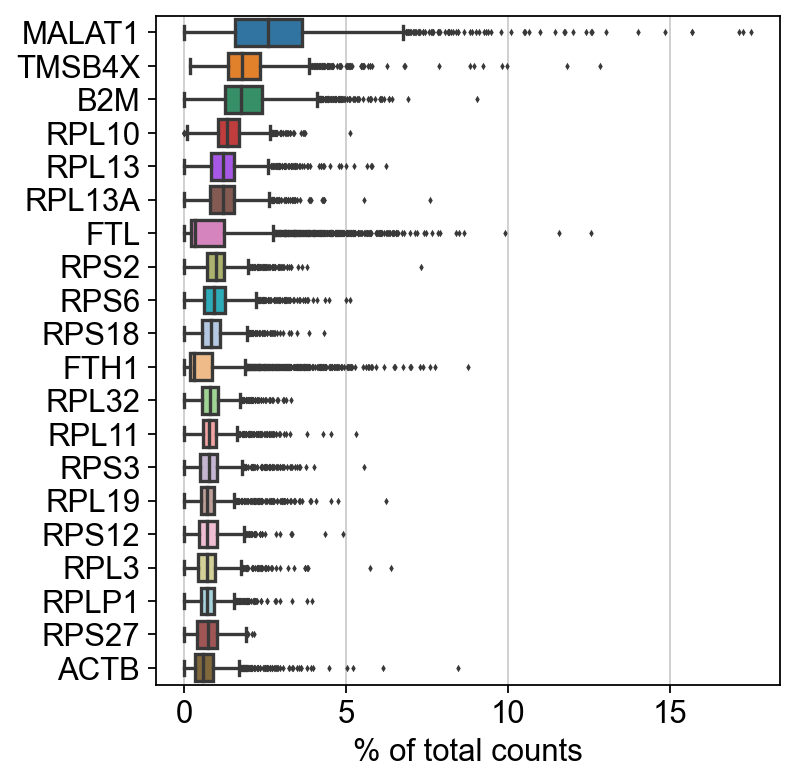

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20, )

### Calculate QC metrics including percent mito and ribo

In [8]:
adata.var['mt']= adata.var_names.str.startswith(("MT-"))
print(sum(adata.var['mt']))

adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
print(sum(adata.var['ribo']))

13
106


### Compute quality control metrics

See Scanpy documentation for more details
https://scanpy.readthedocs.io/en/stable/api/scanpy.pp.calculate_qc_metrics.html

In [9]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

* n_genes_by_counts = Number of genes with positive counts in a cell
* total_counts = Total number of counts for a cell 
* pct_counts_mito = Proportion of total counts for a cell which are mitochondrial

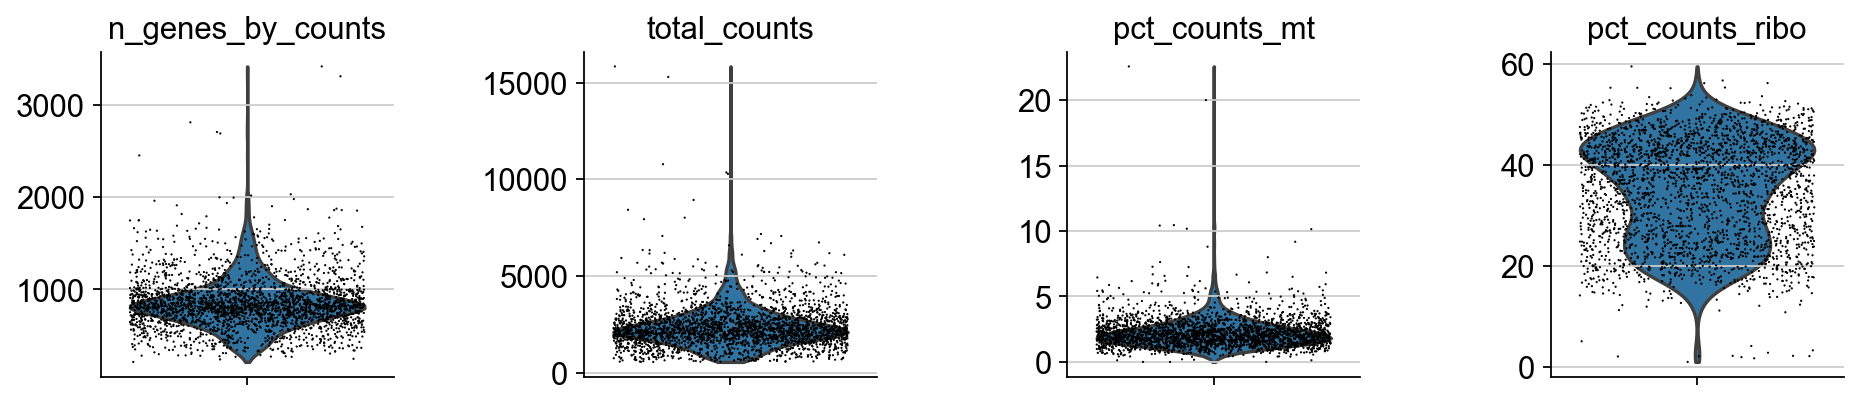

In [10]:
axs = sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],jitter=0.4, multi_panel=True)

Take a snapshot of this object and we can come back later and see what happens to down-stream analysis if we don't do QC filtering.

In [11]:
adBase = adata.copy()

Remove cells that have too many mitochondrial genes or too many total counts.

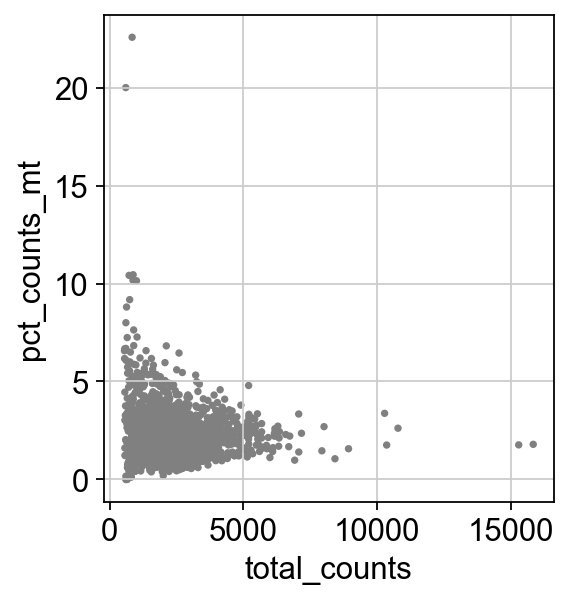

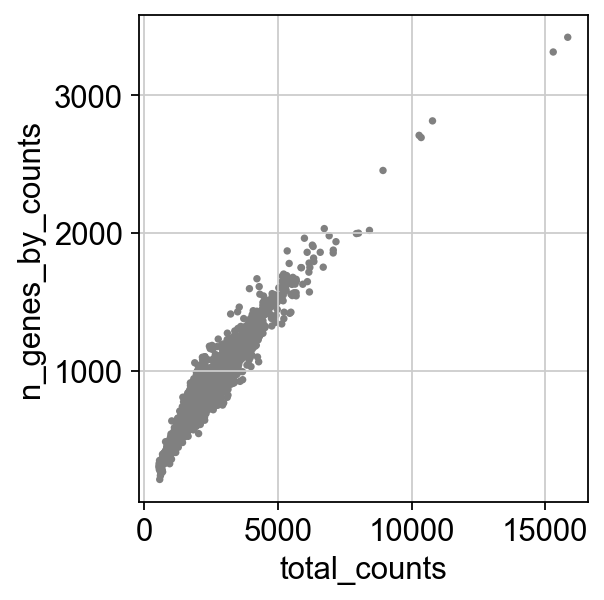

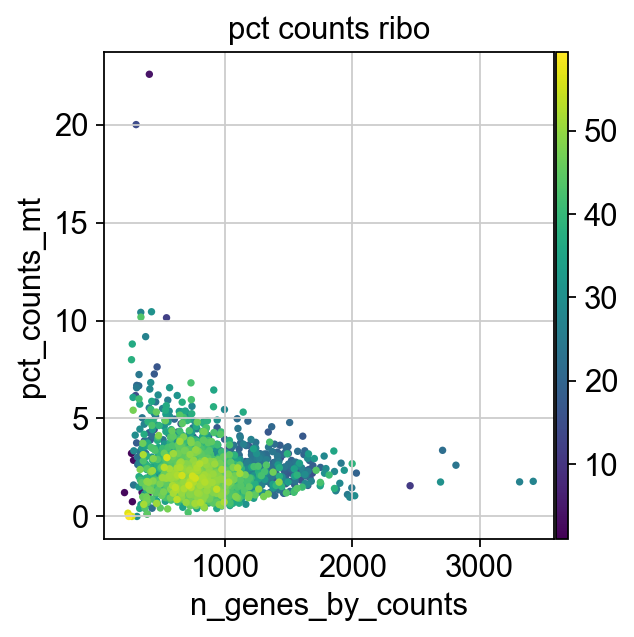

In [12]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(adata, x='n_genes_by_counts', y='pct_counts_mt', color='pct_counts_ribo')

In [13]:
adata = adata[adata.obs.n_genes_by_counts < 2250, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
adata

View of AnnData object with n_obs × n_vars = 2637 × 32738
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

I tend to remove potential doublets based on empirical doublet rate

In [14]:
# thresh = np.percentile(adata.obs['total_counts'],95)
# thresh
# 31382.0

# adata = adata[adata.obs['total_counts'] < thresh, :]

We can rempve ribosomal, mitochondrial, and MALAT1

In [15]:
malat1 = adata.var_names.str.startswith('MALAT1')
mito_genes = adata.var_names.str.startswith('MT-')
ribo_genes = adata.var_names.str.startswith(("RPS","RPL"))
remove = np.add(mito_genes, malat1)
len(remove[remove==True])

14

In [16]:
remove = np.add(remove, ribo_genes)
len(remove[remove==True])

120

In [17]:
keep = np.invert(remove)
len(keep[keep==True])

32618

In [18]:
adata = adata[:,keep]
print(adata.n_obs, adata.n_vars)

2637 32618


### Filter genes and normalize

In [19]:
adNorm = adata.copy()

# remove undetected genes
sc.pp.filter_genes(adNorm, min_cells=5)

adNorm
# AnnData object with n_obs × n_vars = 3541 × 21009

# normalize etc
sc.pp.normalize_per_cell(adNorm, counts_per_cell_after=1e4)
sc.pp.log1p(adNorm)

filtered out 20228 genes that are detected in less than 5 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


### Identify highly variable genes

In [20]:
sc.pp.highly_variable_genes(adNorm, min_mean=0.0125, max_mean=4, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


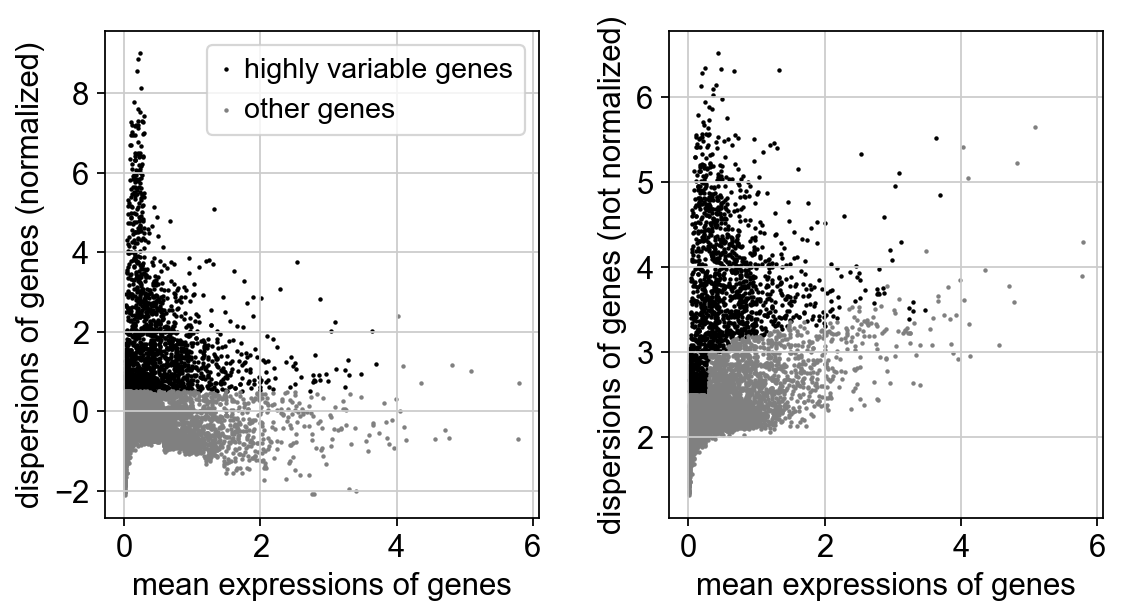

In [21]:
sc.pl.highly_variable_genes(adNorm)

Scale genes for PCA

In [22]:
adNorm.raw = adNorm
sc.pp.scale(adNorm, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [23]:
sc.tl.pca(adNorm)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


Plot and color by expression of marker genes:
* NKG7: Natural killer cells
* CST3: Dendritic cells
* CD79A: B cells

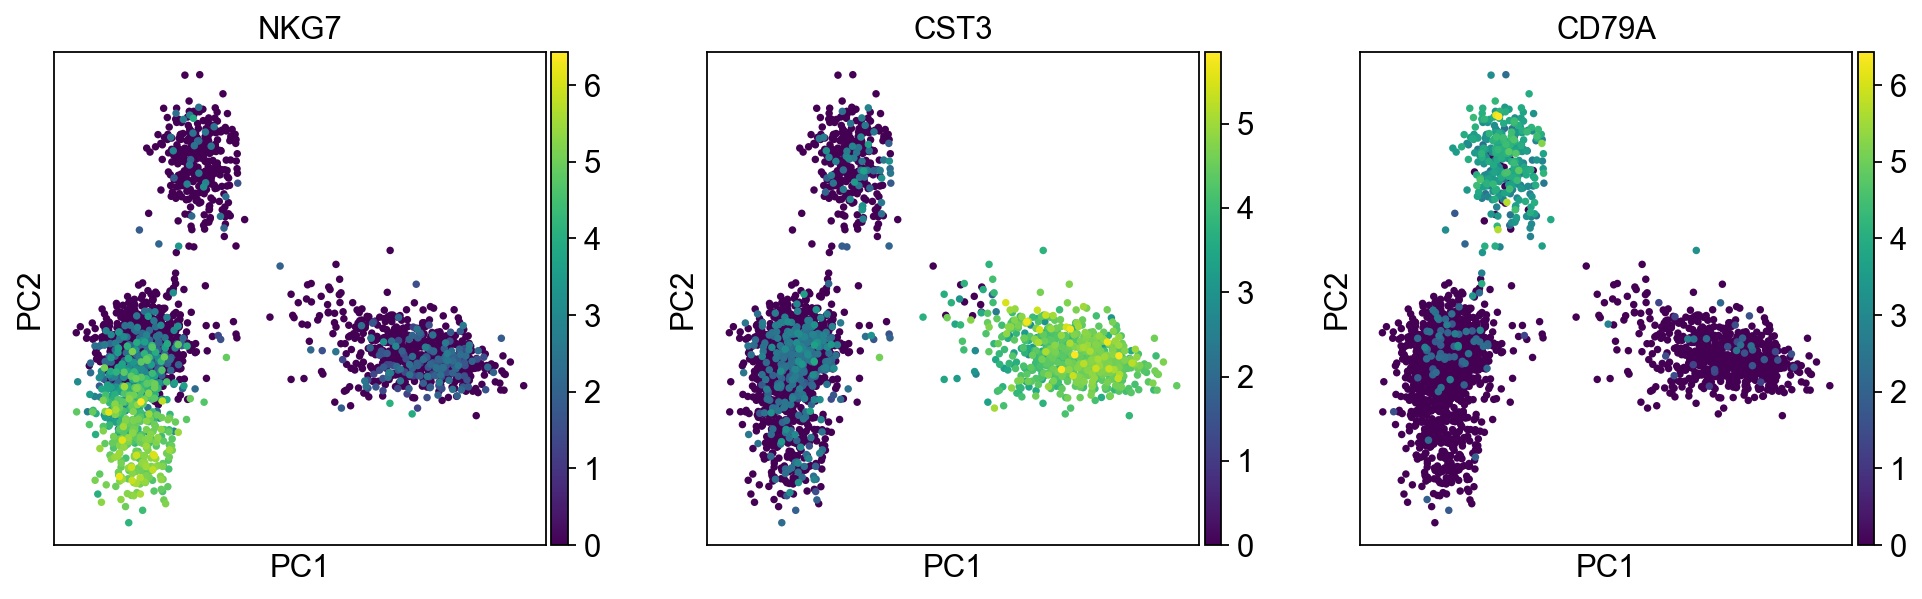

In [24]:
sc.pl.pca(adNorm, color=['NKG7', 'CST3', 'CD79A'])

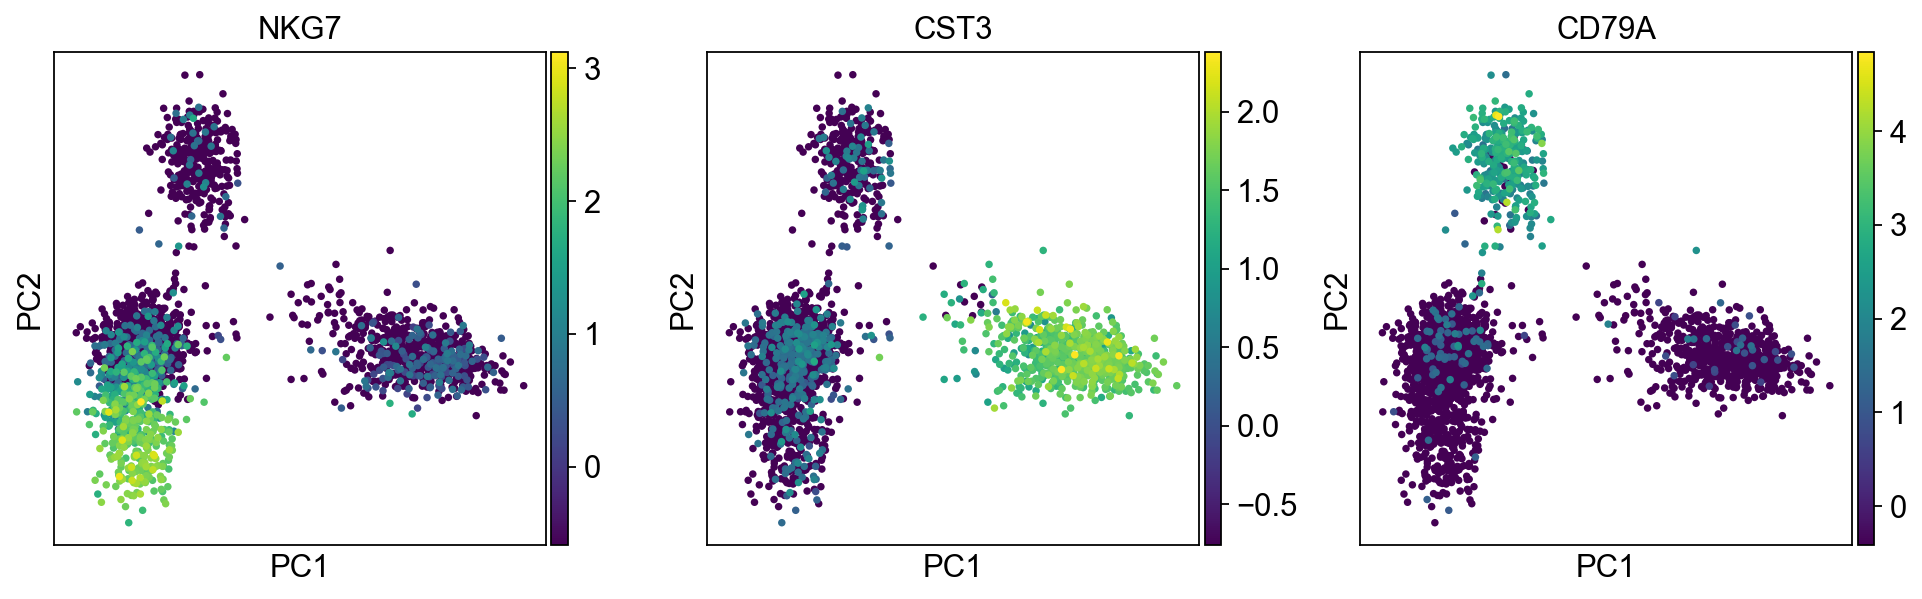

In [25]:
sc.pl.pca(adNorm, color=['NKG7', 'CST3', 'CD79A'], use_raw=False)

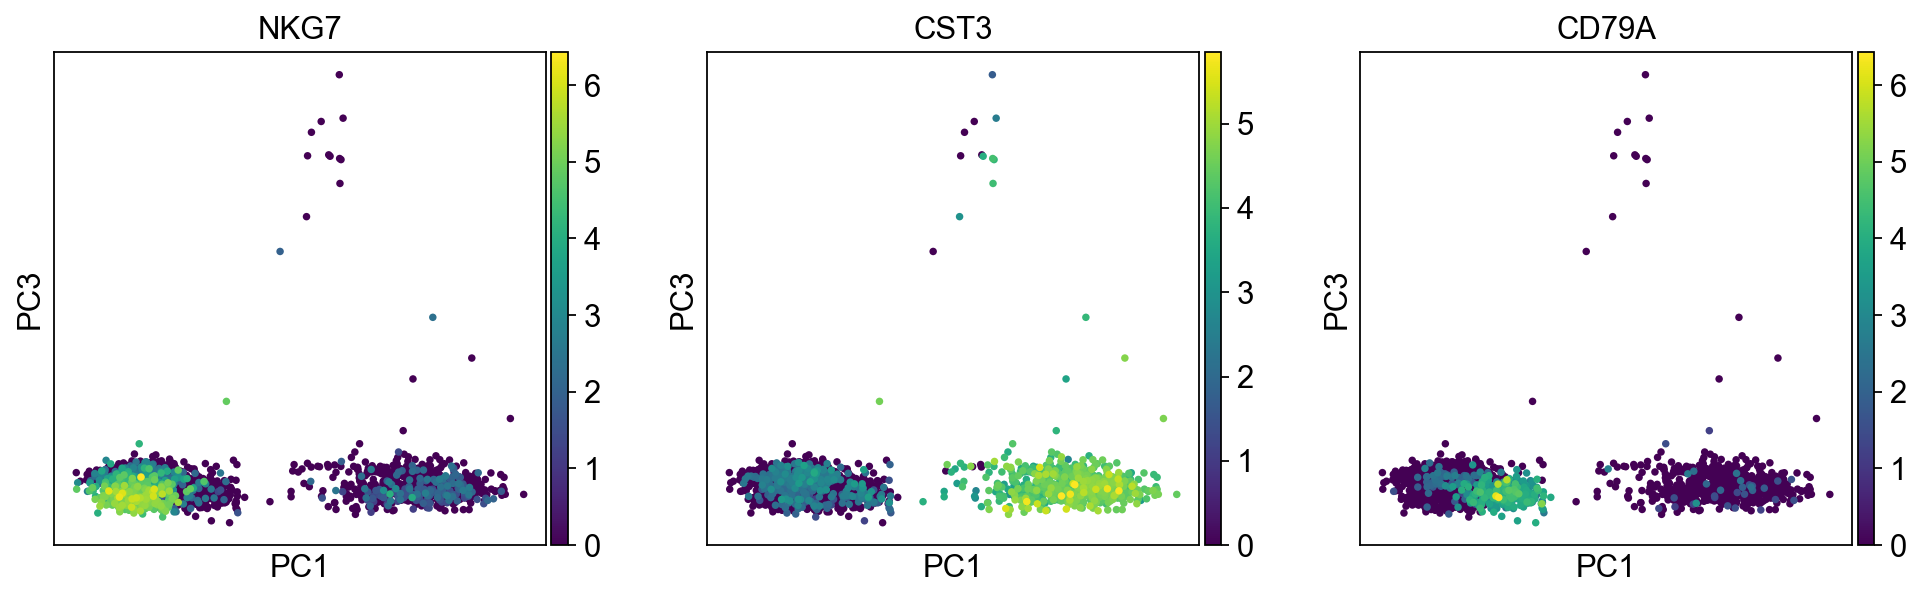

In [26]:
sc.pl.pca(adNorm, color=['NKG7', 'CST3', 'CD79A'], components='1,3')

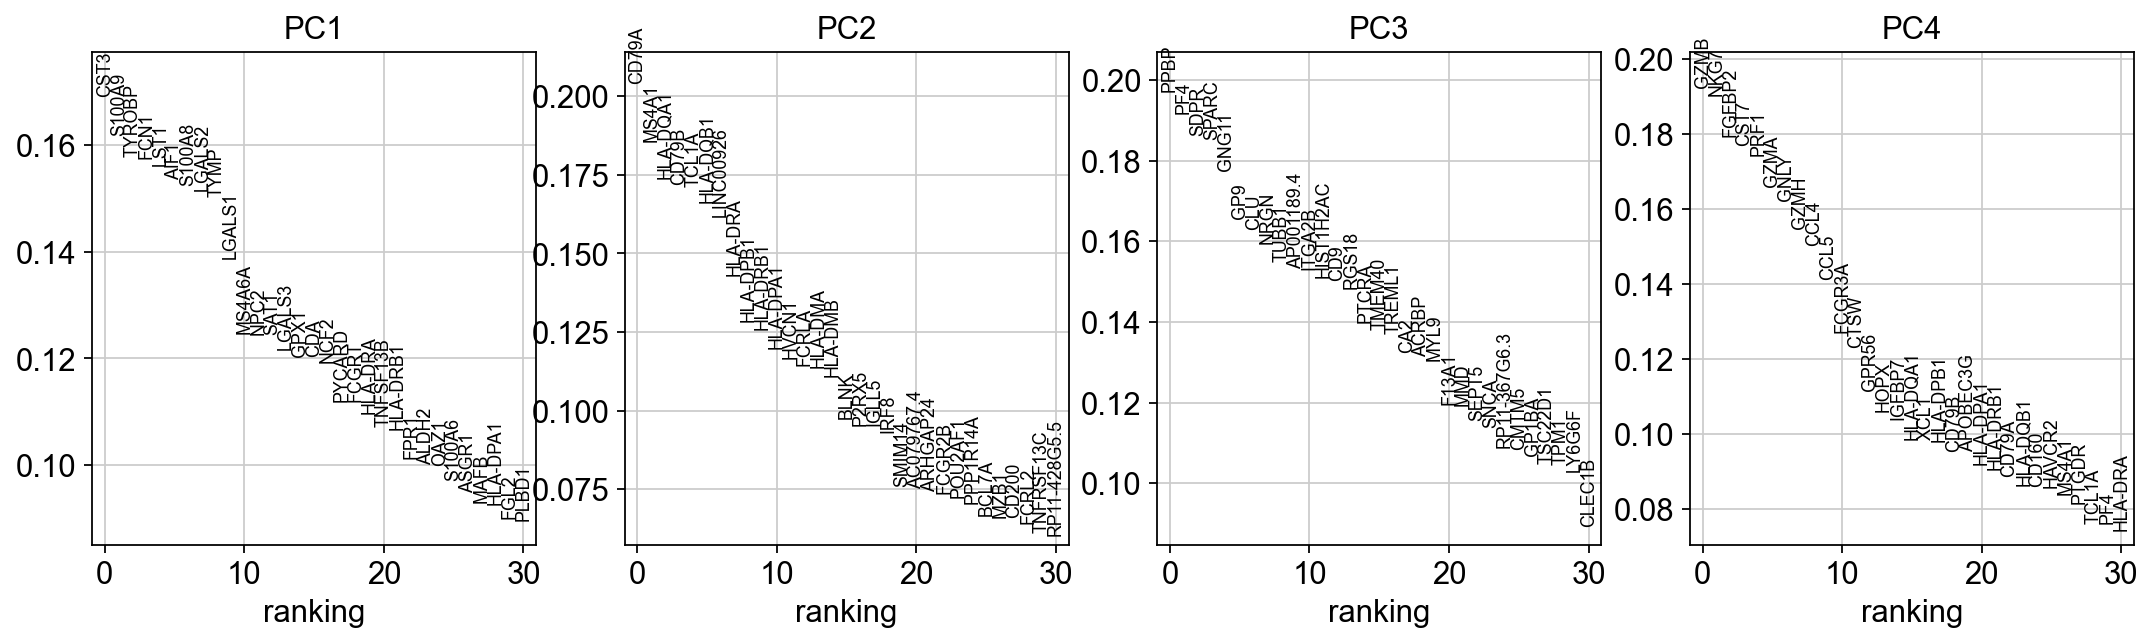

In [27]:
sc.pl.pca_loadings(adNorm, components='1,2,3,4', include_lowest=False)

### Marker genes
* GNLY: Natural killer cell
* CD8A & CD8B: CD8 T cells
* IL7R & CD4: CD4 T cells

* CD79A: B cells

* PPBP: Megakaryocytes
* FCER1A: Dendritic cells
* CD14 & S100A8: CD14 Monocytes
* MS4A7: FCGR3A Monocytes

In [28]:
marker_genes = ['GNLY', 'CD8A', 'CD8B', 'IL7R', 'CD4', 'CD79A', 'PPBP','FCER1A', 'CD14','S100A8','MS4A7']

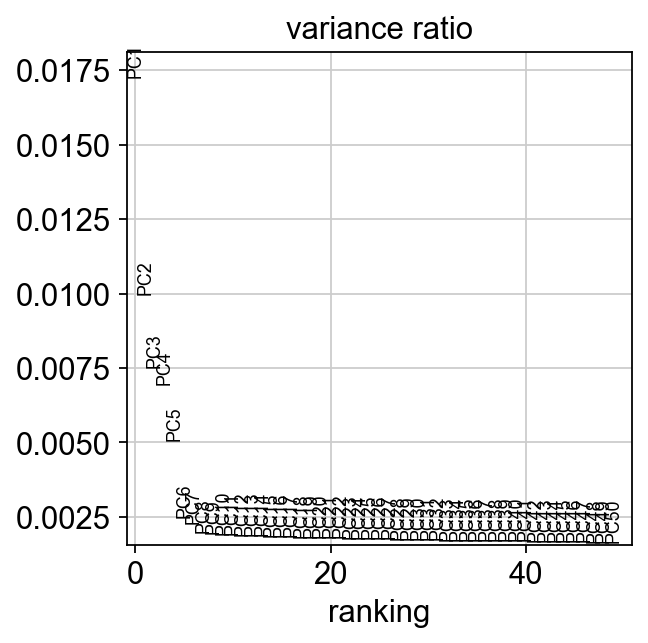

In [29]:
sc.pl.pca_variance_ratio(adNorm, 50)

In [30]:
npcs = 10
sc.pp.neighbors(adNorm, n_neighbors=10, n_pcs=npcs)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


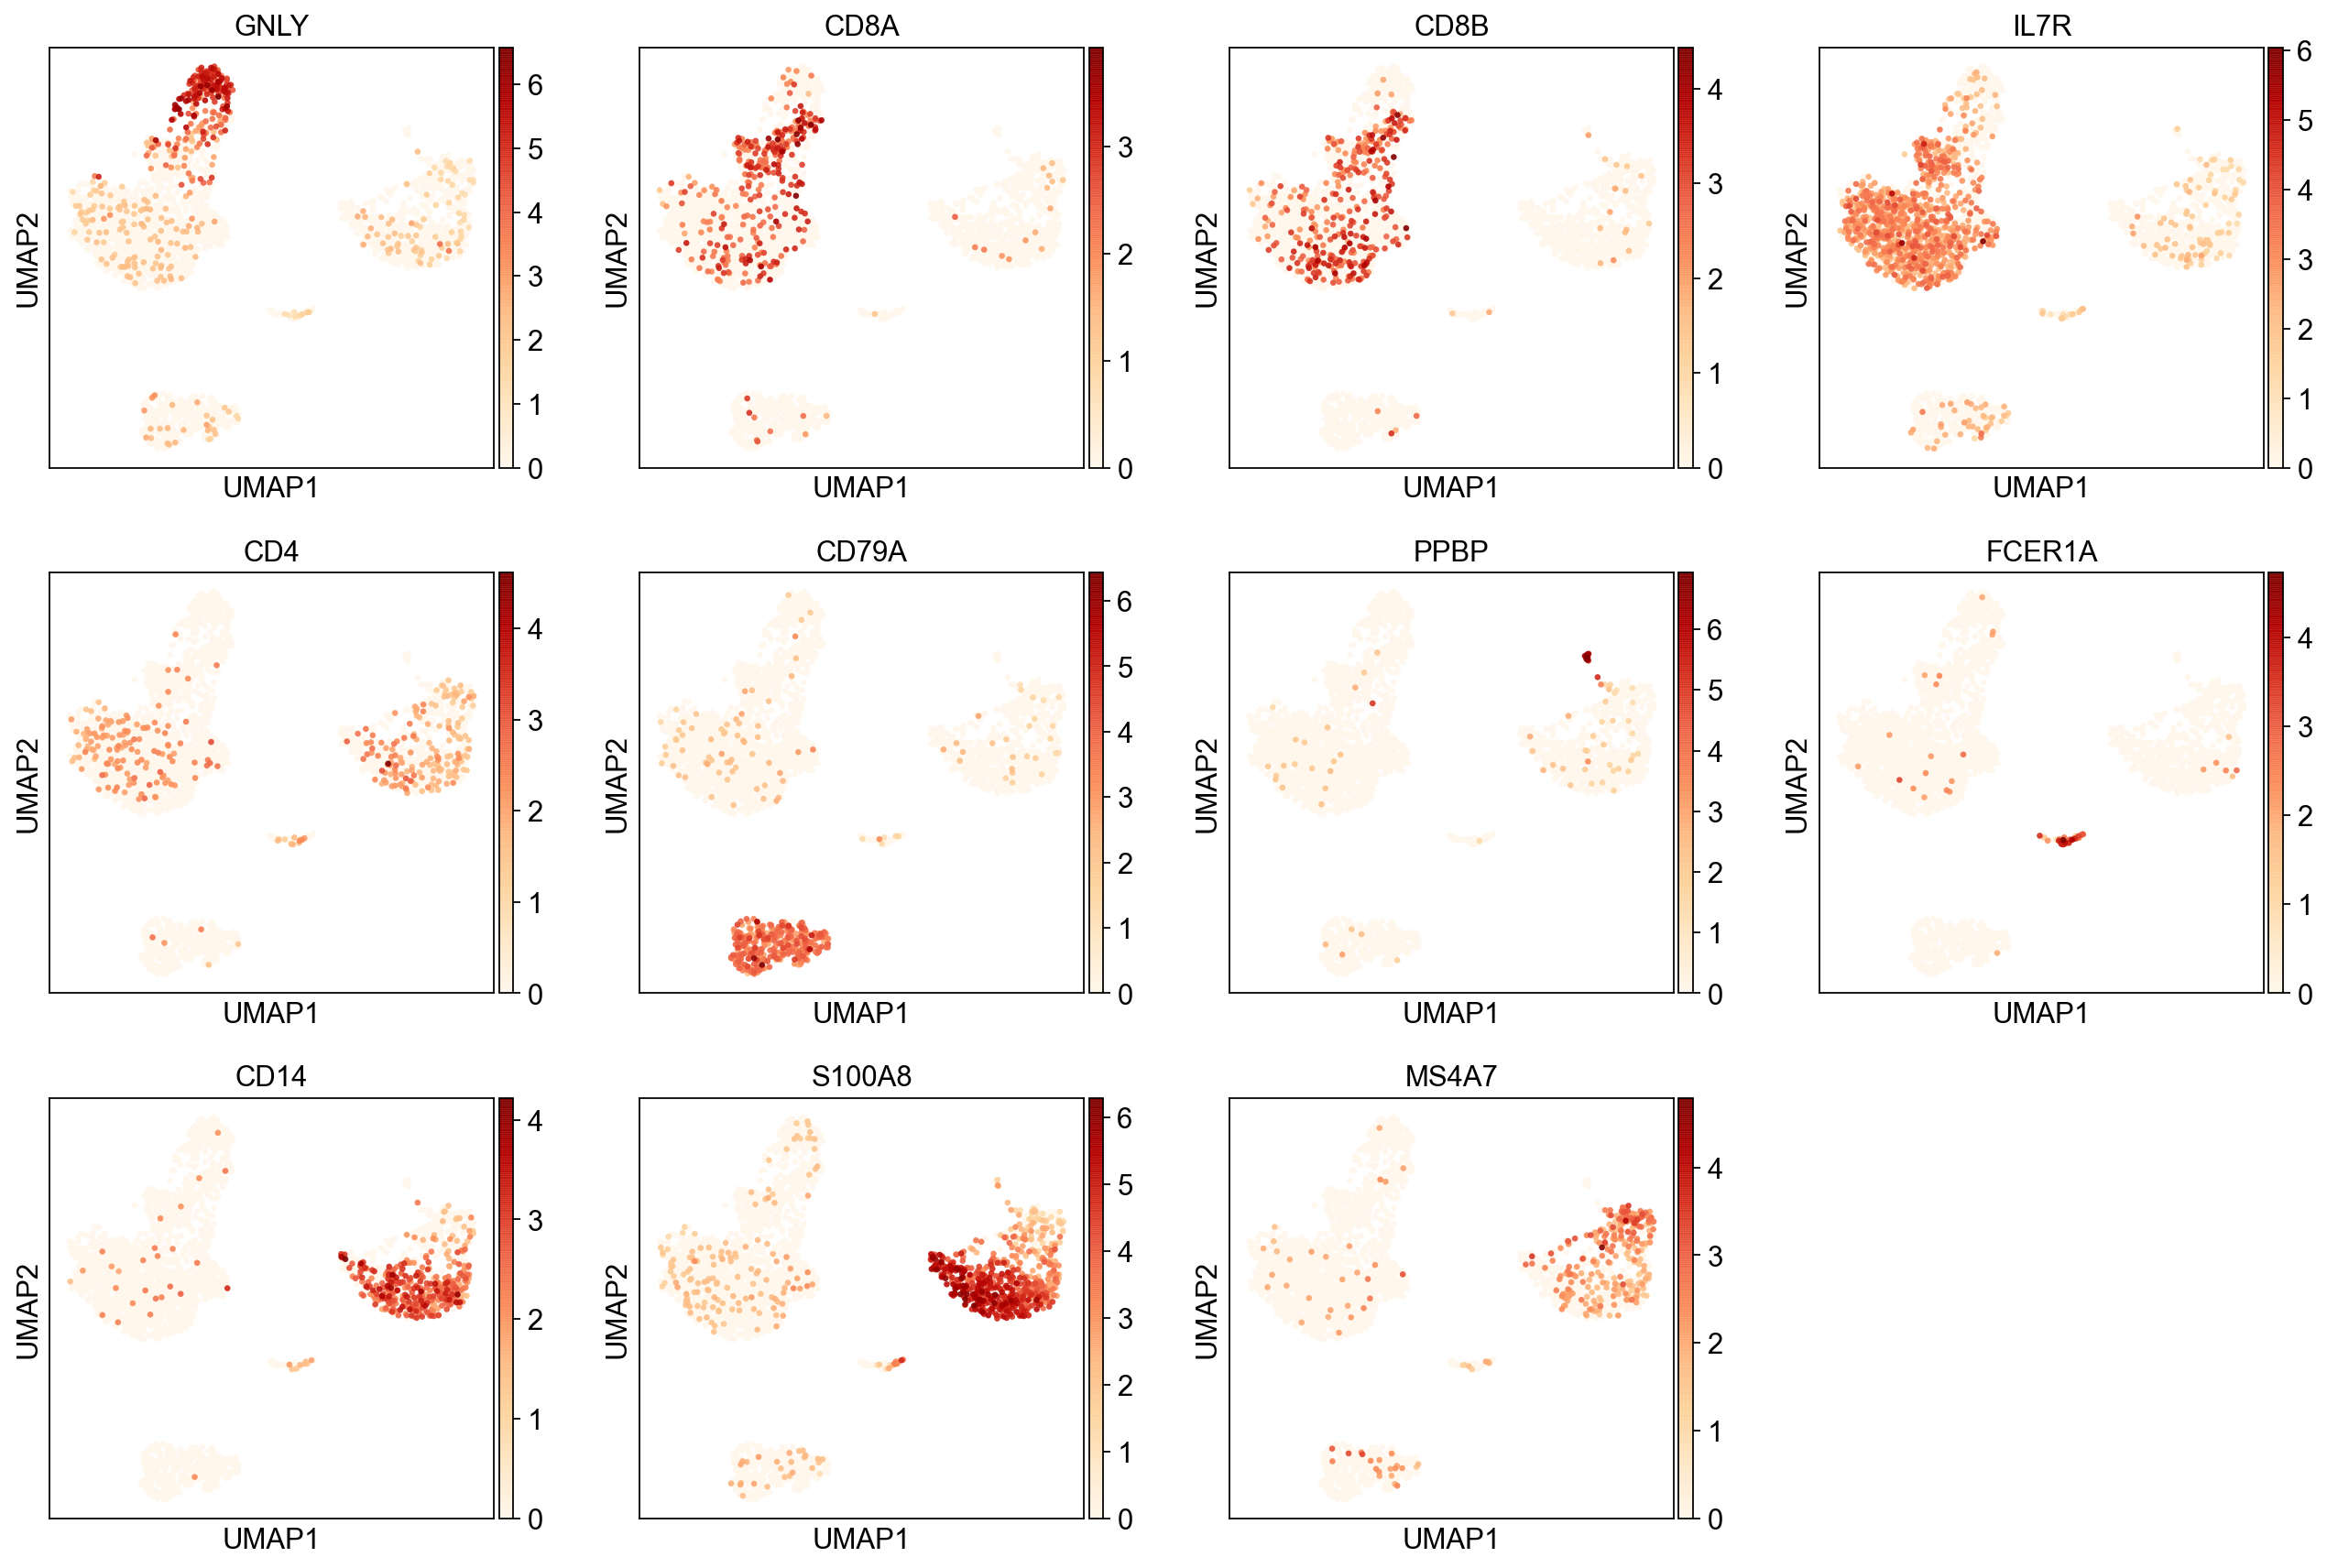

In [31]:
sc.tl.umap(adNorm, .5)
sc.pl.umap(adNorm, color=marker_genes, alpha=.9, s=35, cmap='OrRd', legend_loc='on data')

computing neighbors
    using 'X_pca' with n_pcs = 3
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


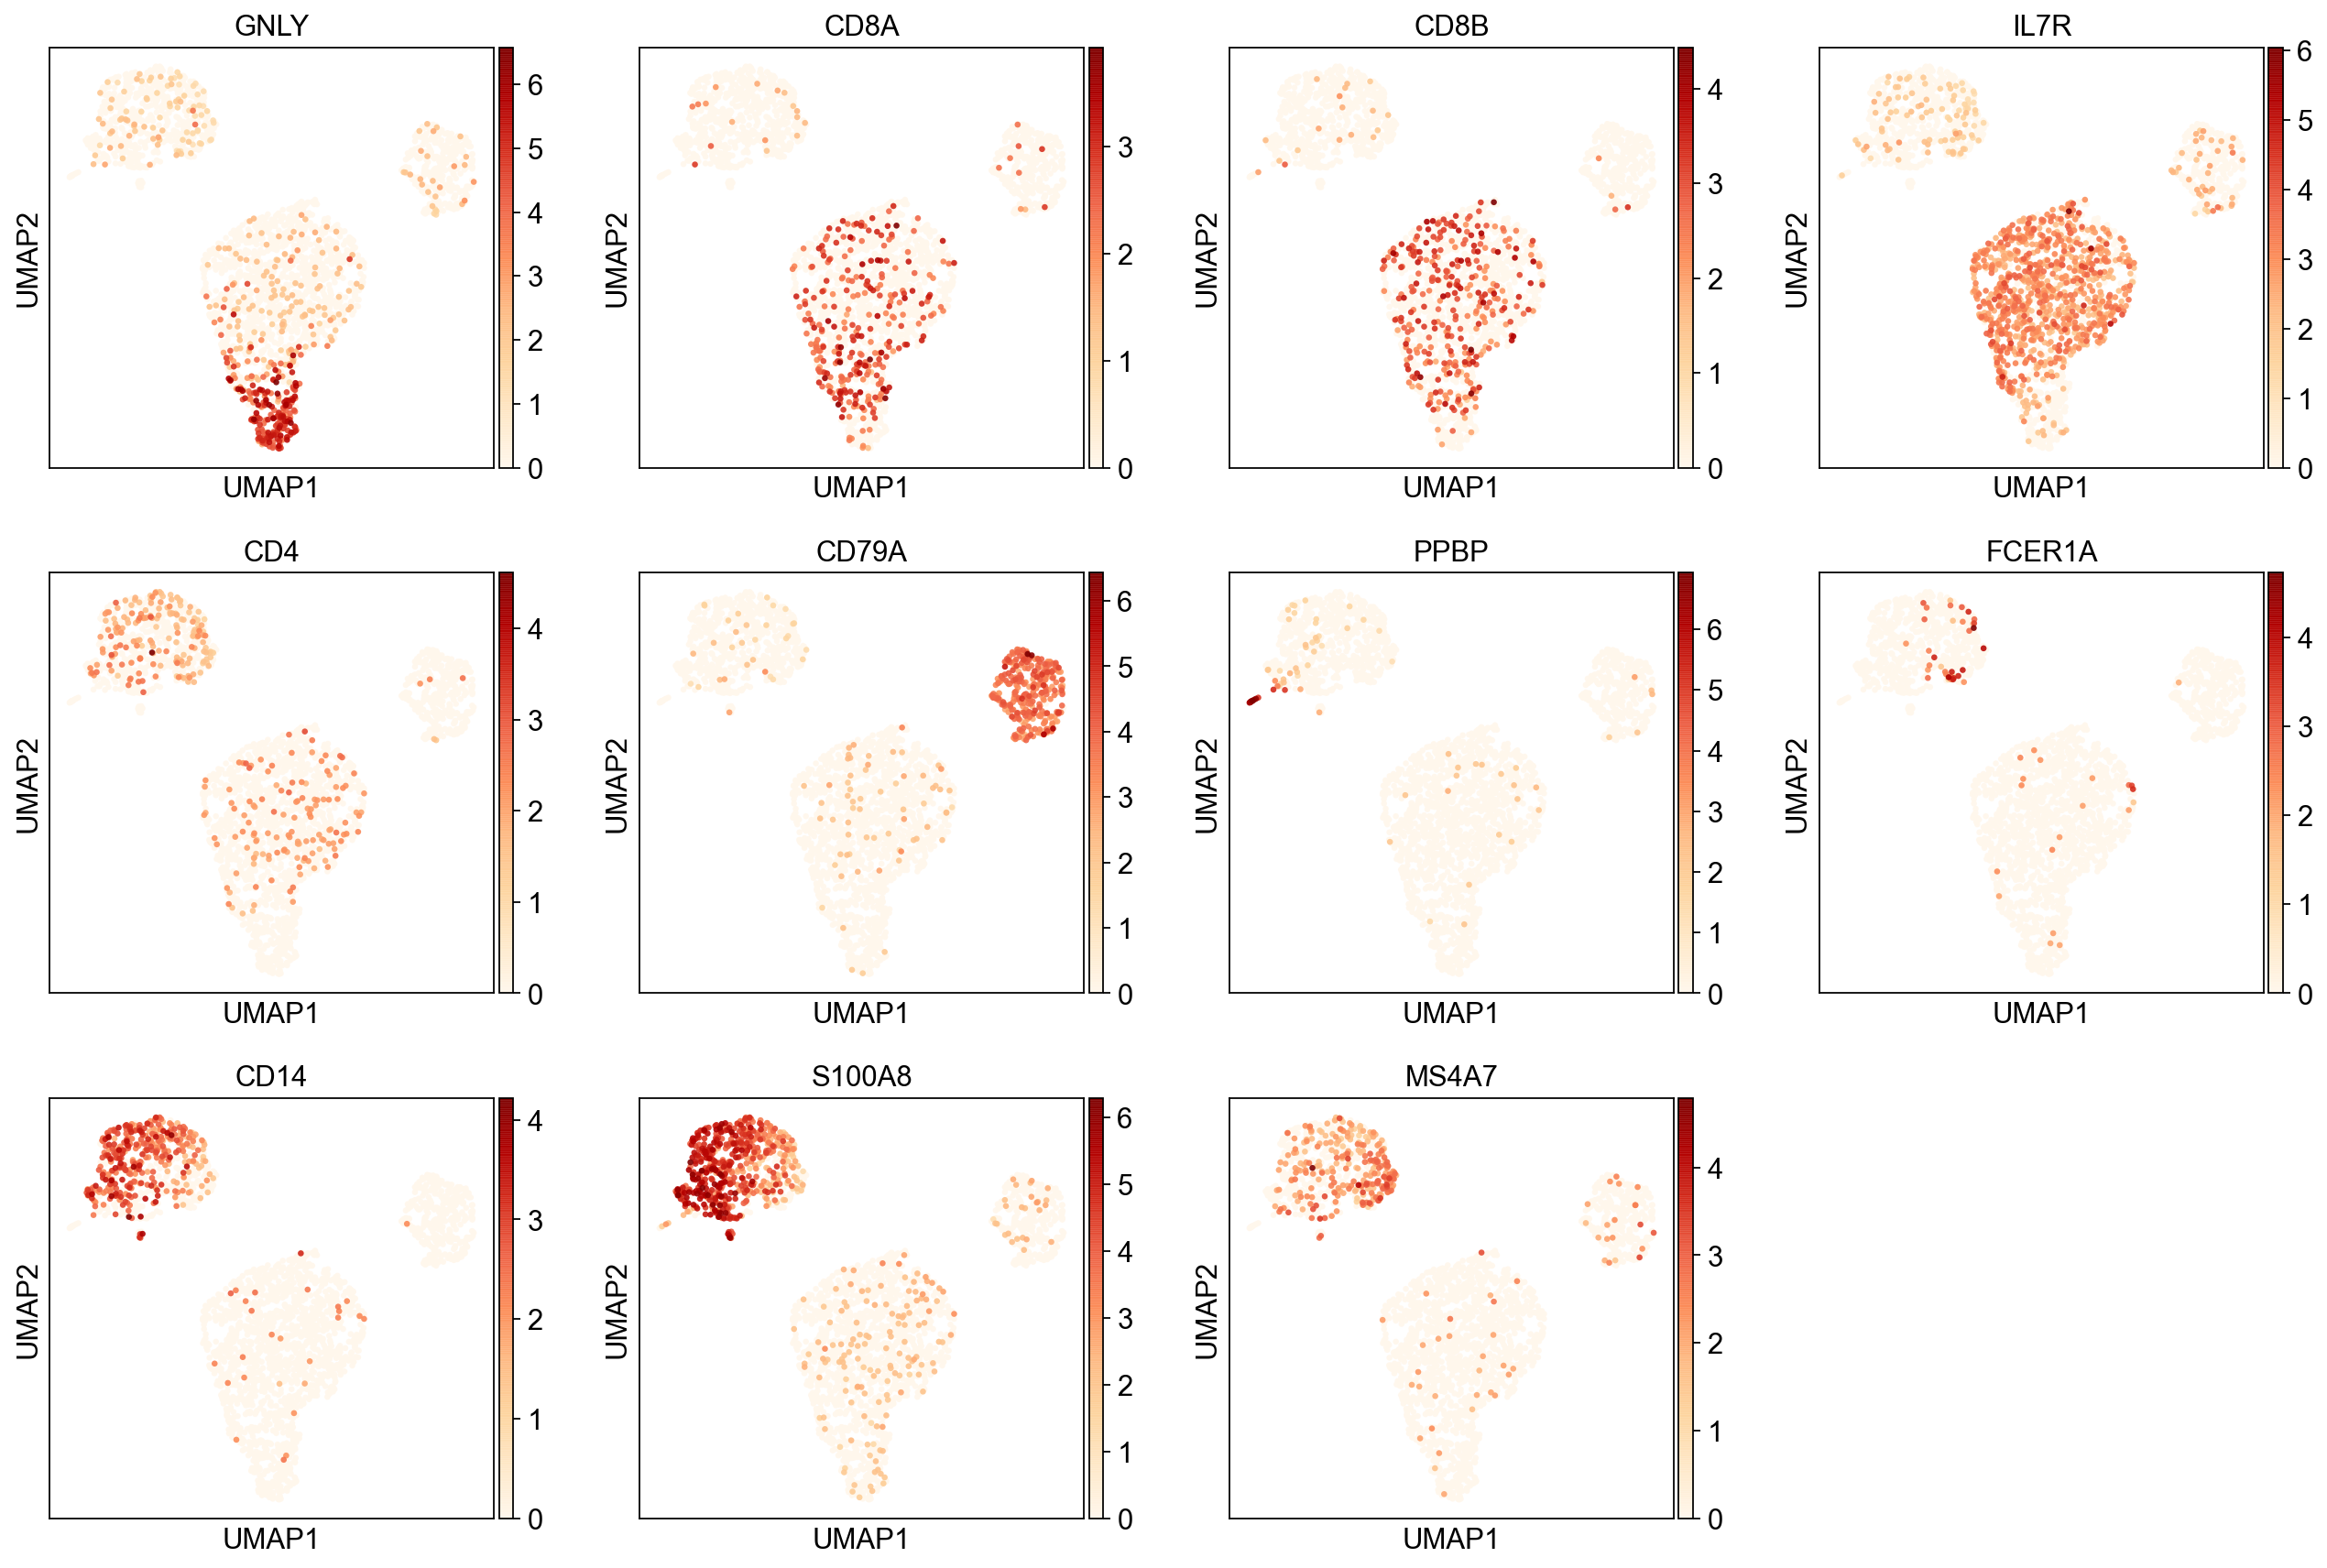

In [32]:
npcs = 3
sc.pp.neighbors(adNorm, n_neighbors=10, n_pcs=npcs)
sc.tl.umap(adNorm, .5)
sc.pl.umap(adNorm, color=marker_genes, alpha=.9, s=35, cmap='OrRd', legend_loc='on data')

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


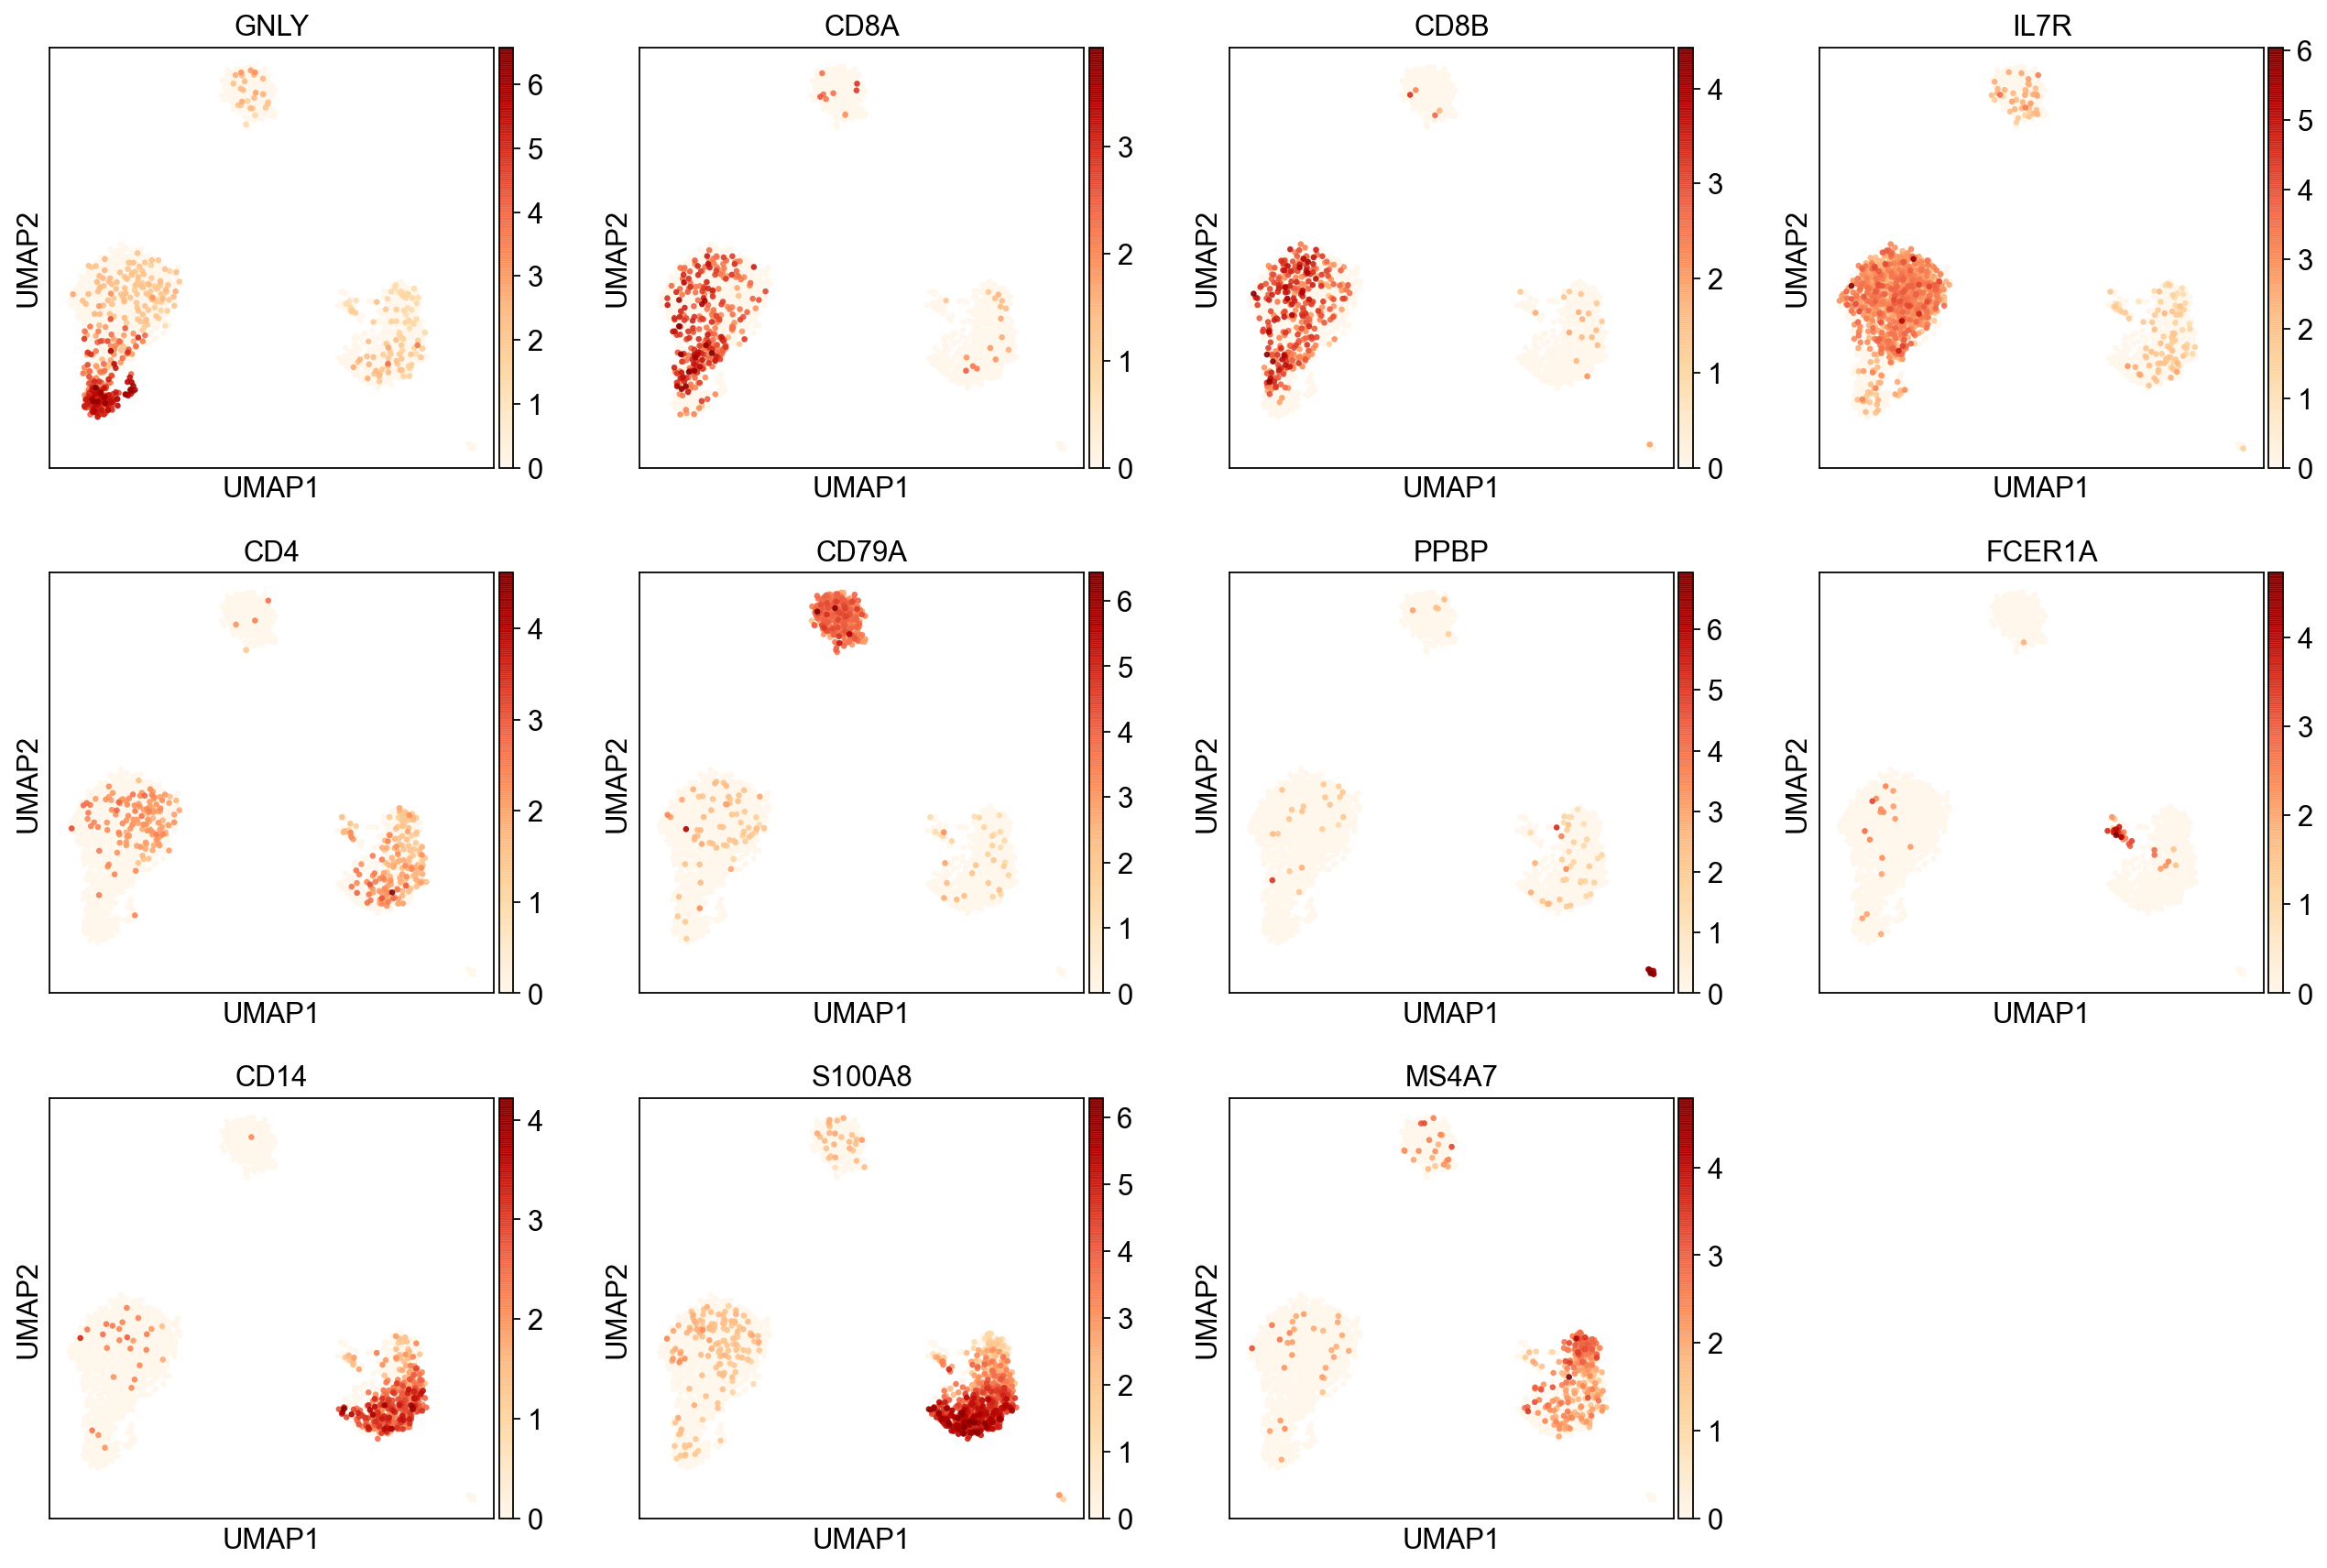

In [33]:
npcs = 50
sc.pp.neighbors(adNorm, n_neighbors=10, n_pcs=npcs)
sc.tl.umap(adNorm, .5)
sc.pl.umap(adNorm, color=marker_genes, alpha=.9, s=35, cmap='OrRd', legend_loc='on data')

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


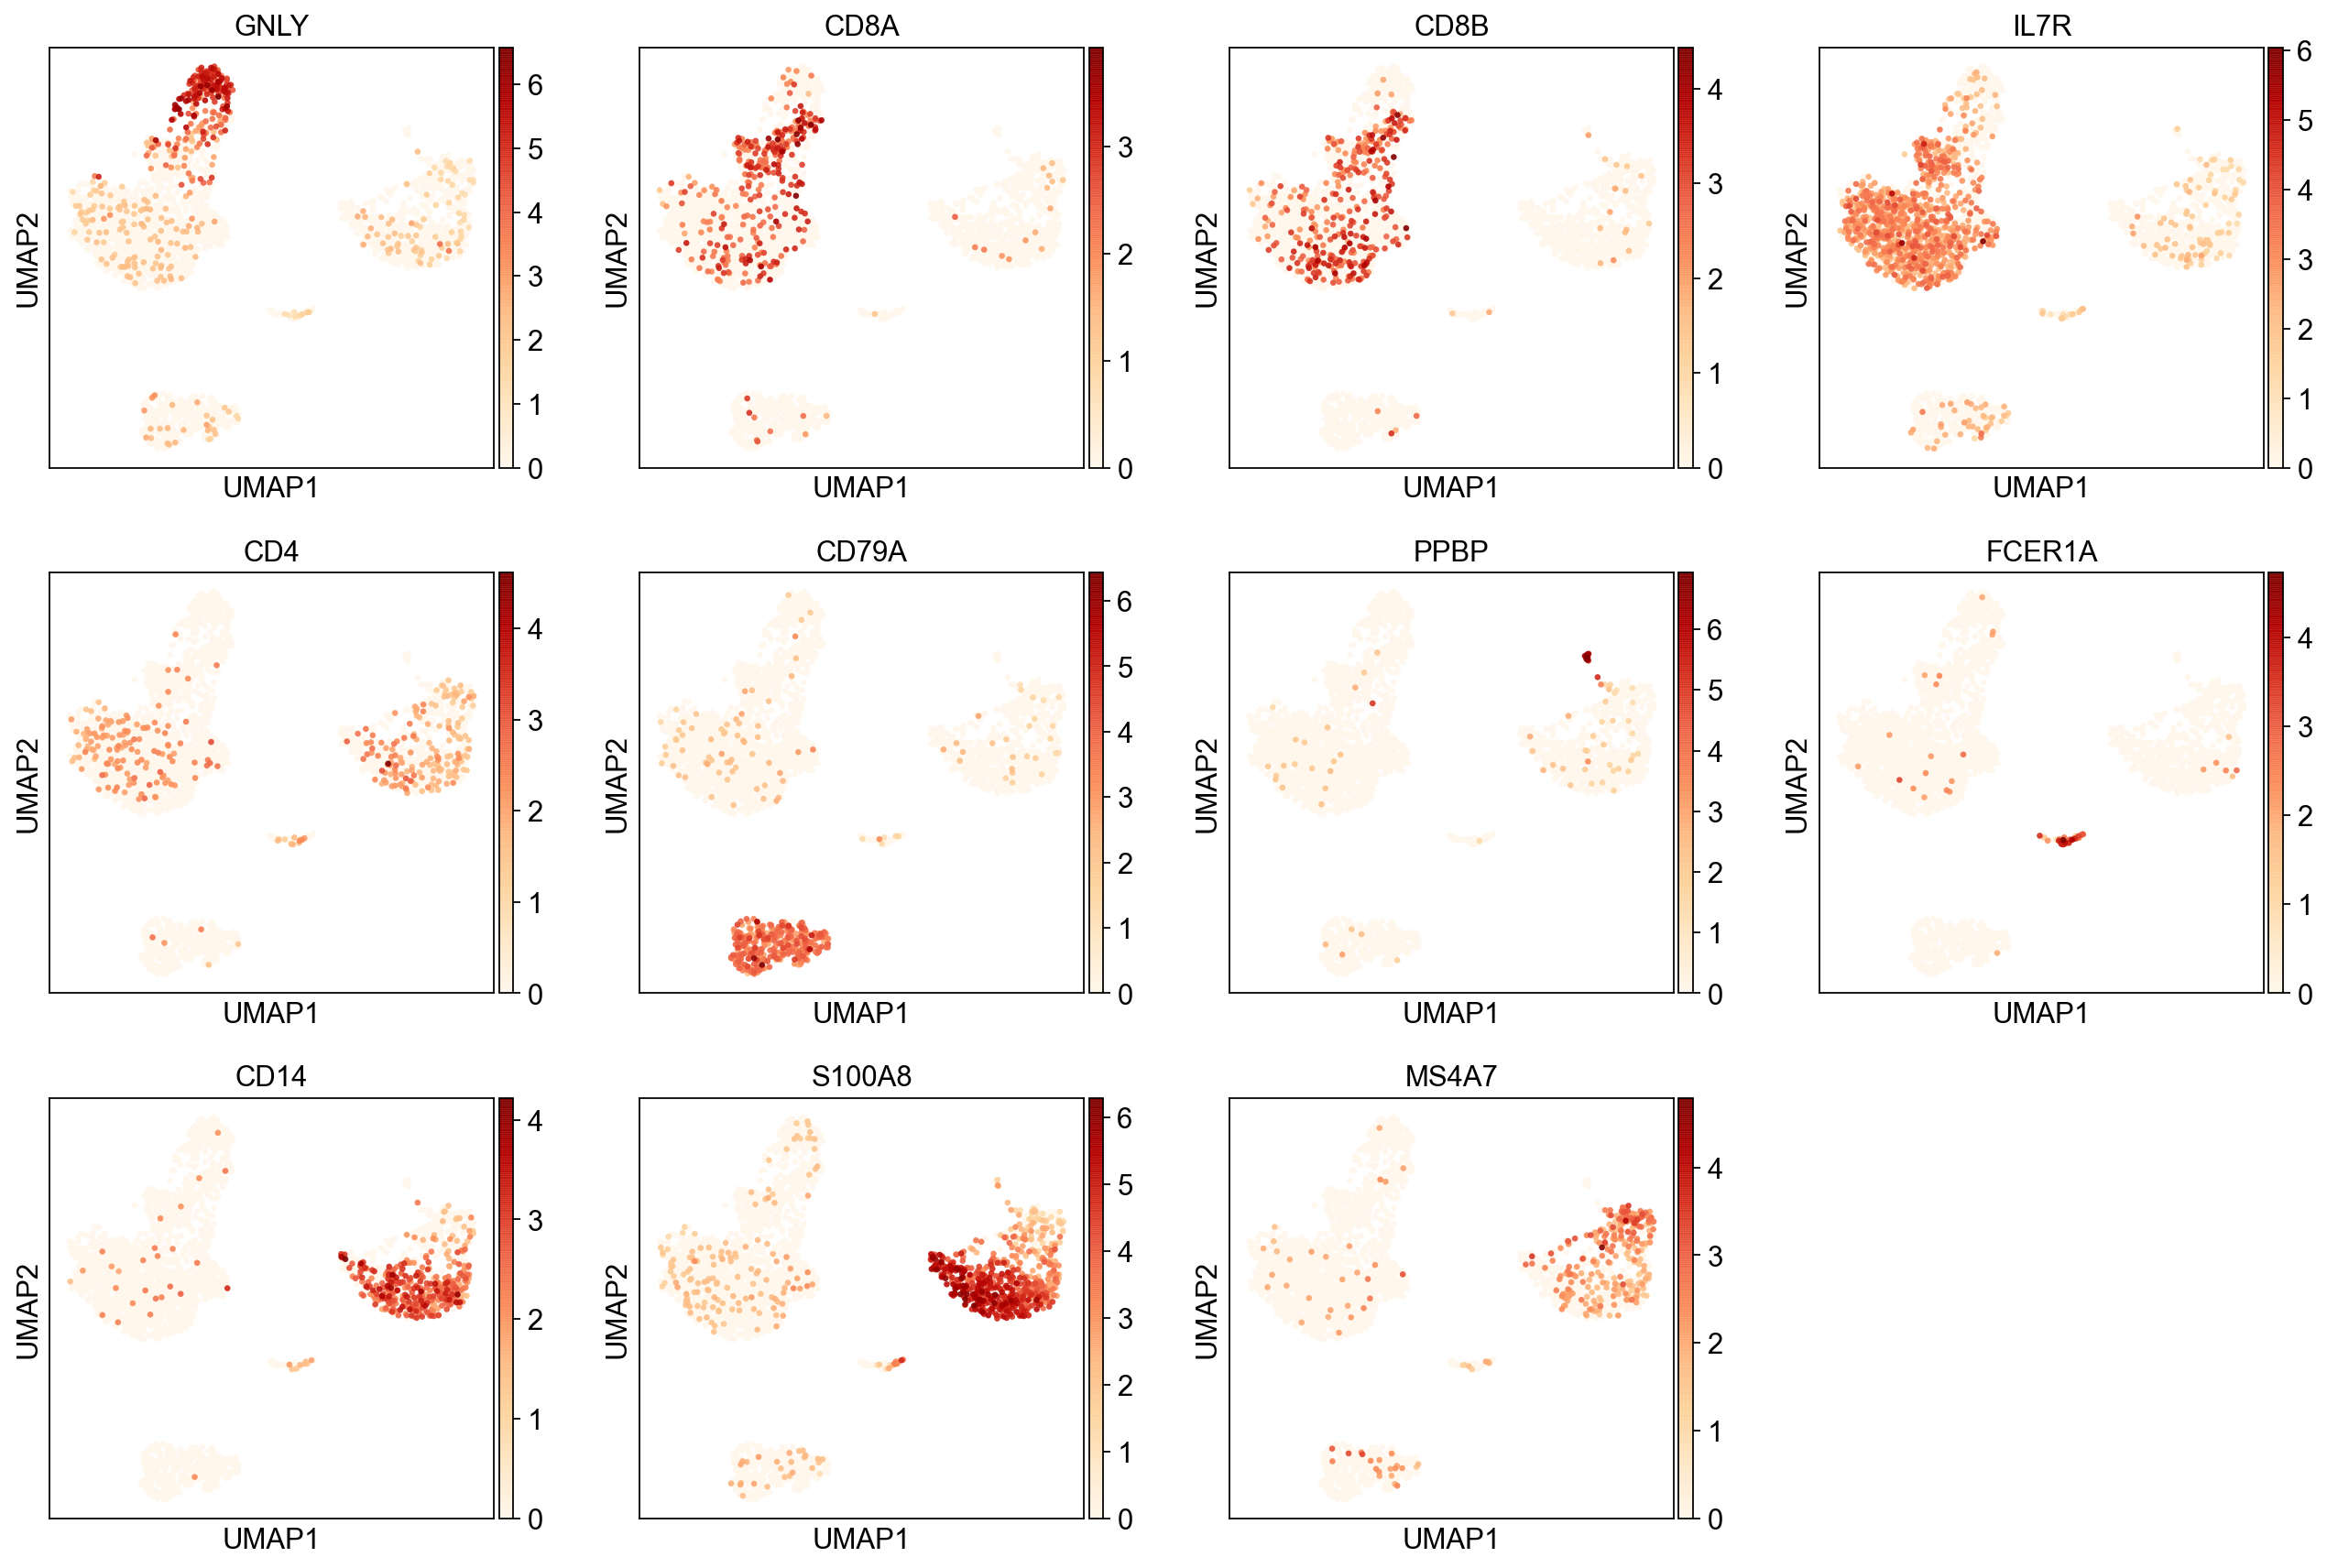

In [34]:
npcs = 10
sc.pp.neighbors(adNorm, n_neighbors=10, n_pcs=npcs)
sc.tl.umap(adNorm, .5)
sc.pl.umap(adNorm, color=marker_genes, alpha=.9, s=35, cmap='OrRd', legend_loc='on data')

### Now cluster
Use community detection algorithm Leiden

In [35]:
sc.tl.leiden(adNorm, .5)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


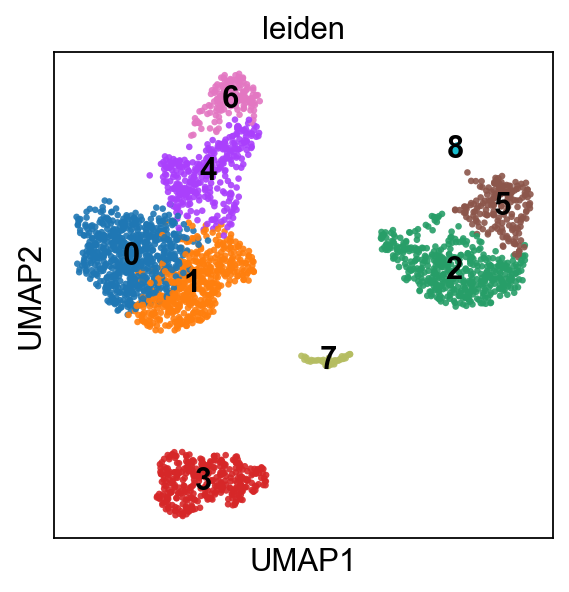

In [36]:
sc.pl.umap(adNorm, color=['leiden'], alpha=.9, s=35, cmap='OrRd', legend_loc='on data')

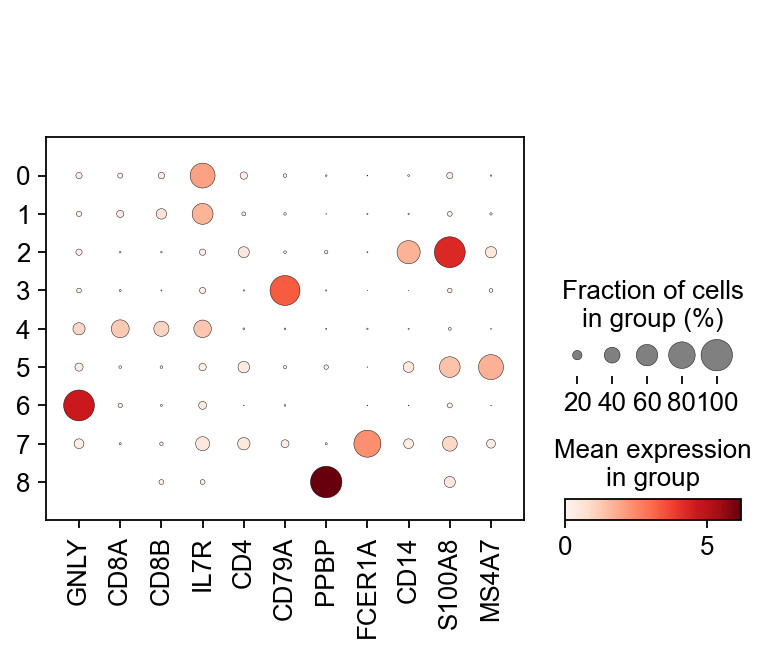

In [37]:
sc.pl.dotplot(adNorm, marker_genes, groupby='leiden')

### Re-name clusters
* GNLY: Natural killer cell
* CD8A & CD8B: CD8 T cells
* IL7R & CD4: CD4 T cells

* CD79A: B cells

* PPBP: Megakaryocytes
* FCER1A: Dendritic cells
* CD14 & S100A8: CD14 Monocytes
* MS4A7: FCGR3A Monocytes

In [38]:
new_cluster_names = [
    'CD4 T 1', 'CD4 T2','CD14 Monocytes',
    'B', 'CD8 T',
    'FCGR3A Monocytes','NK', 
    'Dendritic', 'Megakaryocytes']
adNorm.rename_categories('leiden', new_cluster_names)

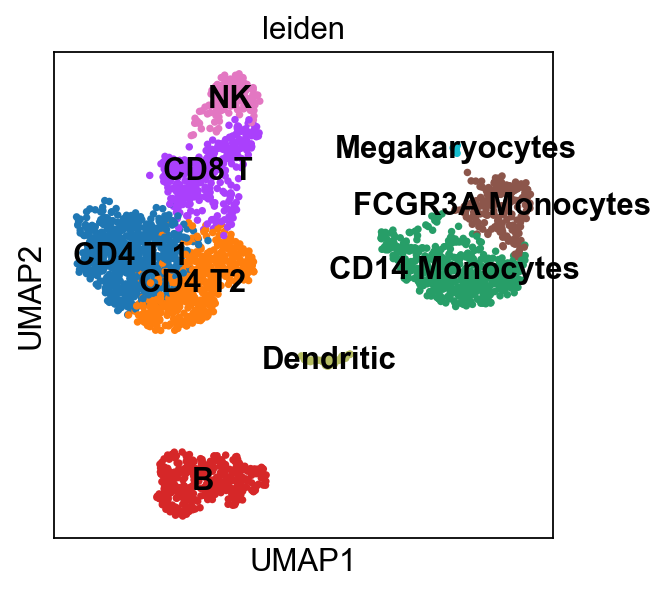

In [39]:
sc.pl.umap(adNorm, color='leiden', legend_loc='on data')

### differential gene expression
t-test and Wilcoxon rank-sum

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


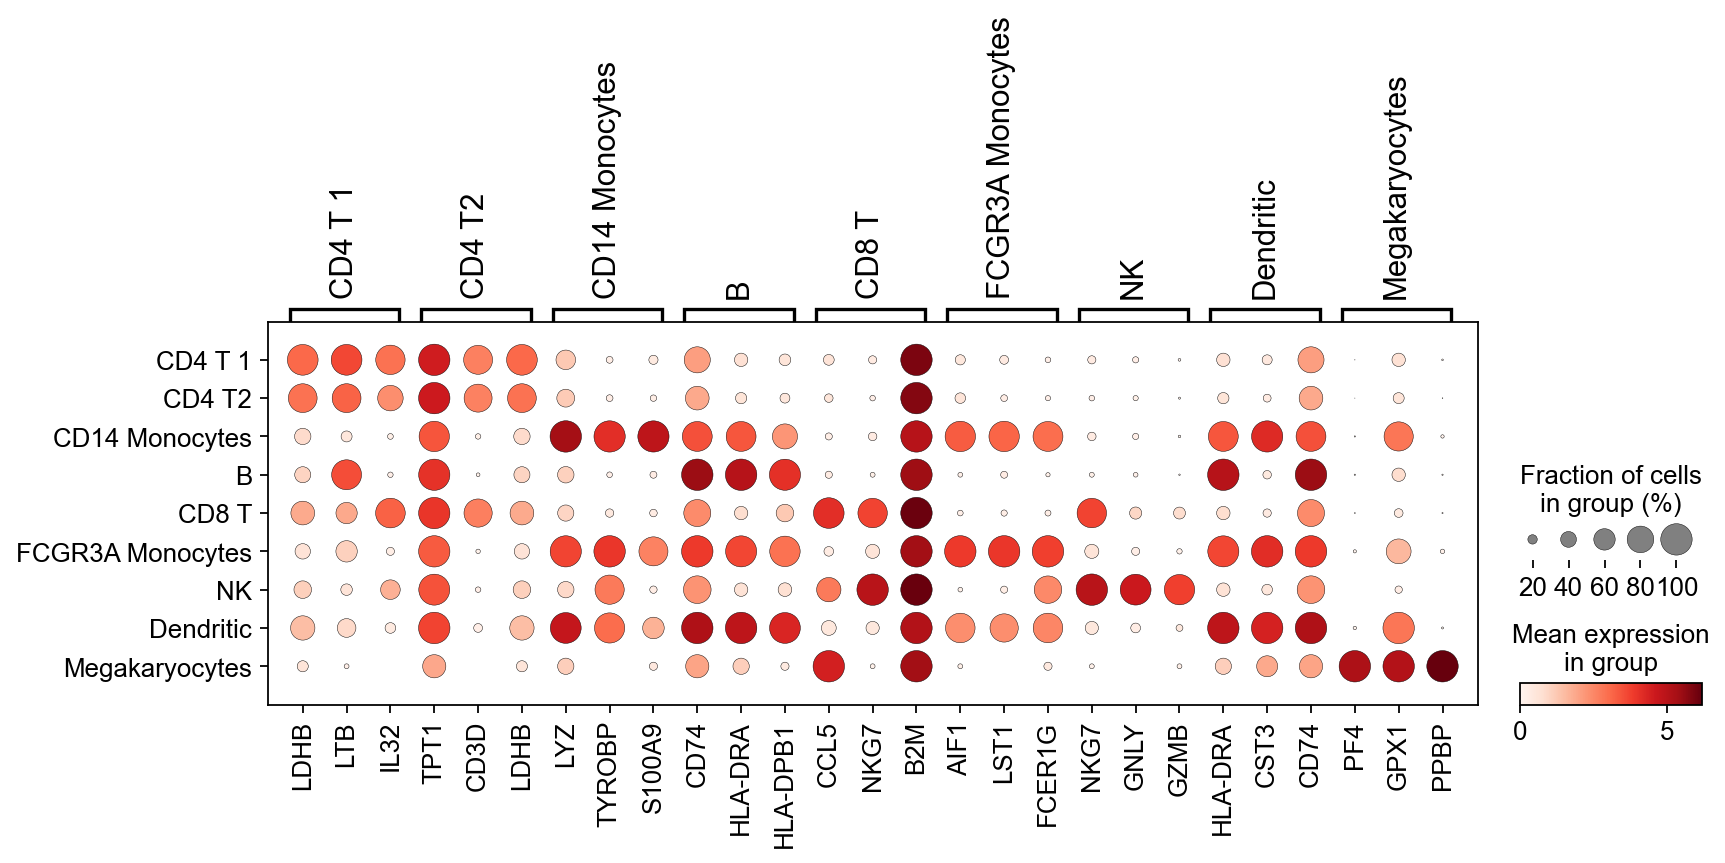

In [40]:
sc.tl.rank_genes_groups(adNorm, 'leiden', method='t-test', use_raw=True)
sc.pl.rank_genes_groups_dotplot(adNorm, n_genes=3, groupby='leiden', use_raw=True, dendrogram=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


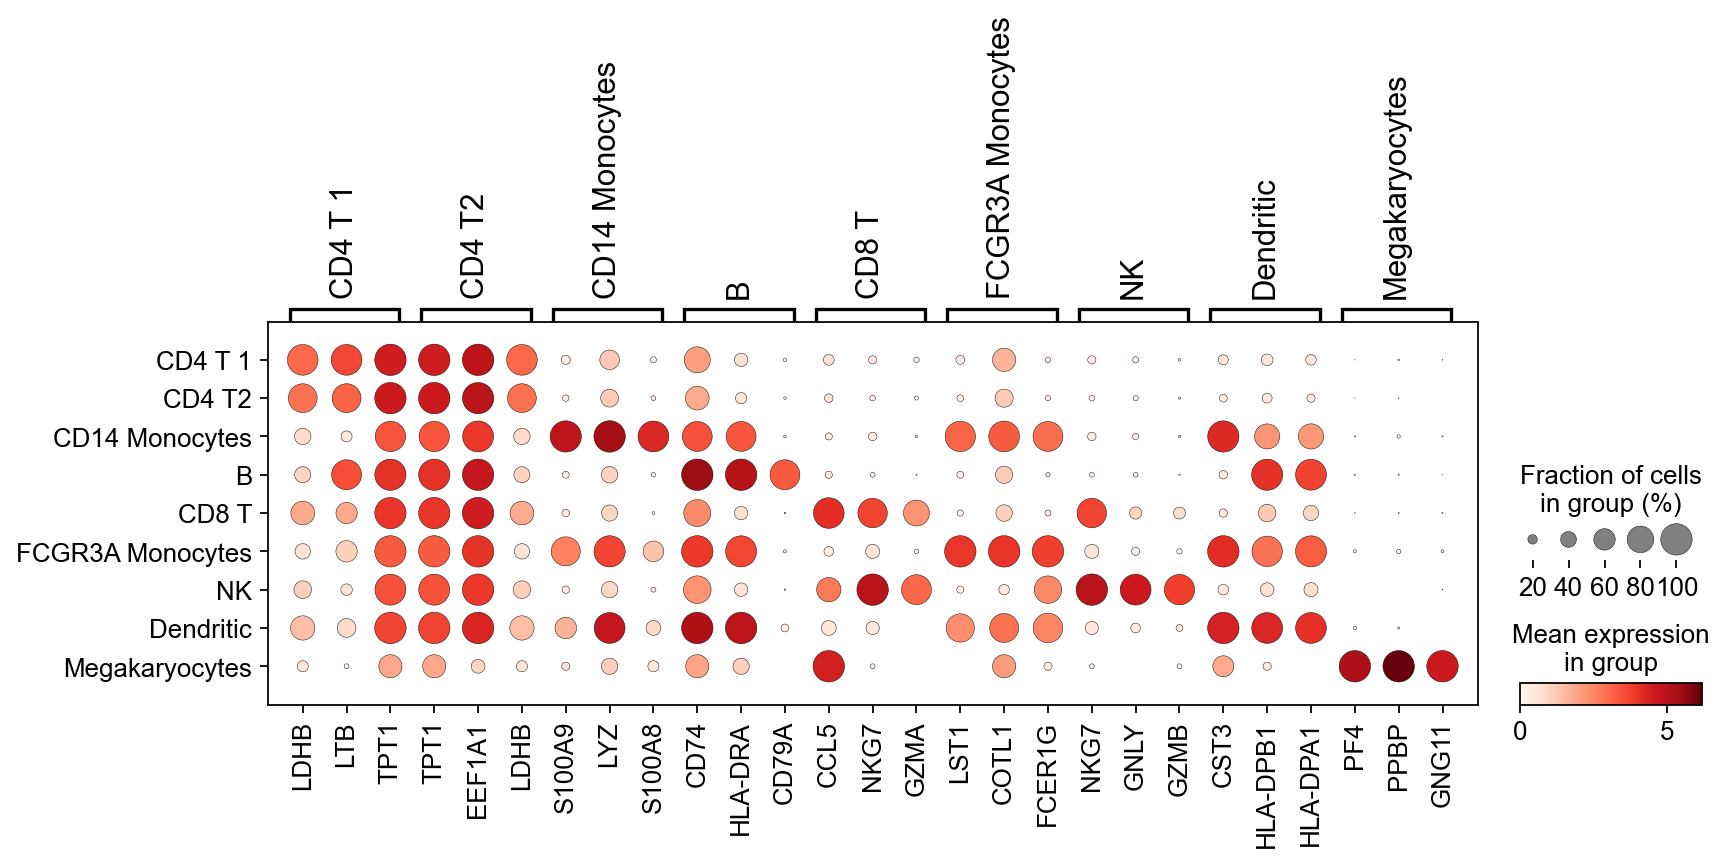

In [41]:
sc.tl.rank_genes_groups(adNorm,'leiden', n_genes=200, use_raw=True, method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adNorm, n_genes=3, groupby='leiden', use_raw=True, dendrogram=False)

In [42]:
pd.DataFrame(adNorm.uns['rank_genes_groups']['names']).head(50)

CD4 T 1     CD4 T2 CD14 Monocytes          B     CD8 T FCGR3A Monocytes  \
0      LDHB       TPT1         S100A9       CD74      CCL5             LST1   
1       LTB     EEF1A1            LYZ    HLA-DRA      NKG7            COTL1   
2      TPT1       LDHB         S100A8      CD79A      GZMA           FCER1G   
3      IL32       CD3D         TYROBP   HLA-DPB1      CST7             AIF1   
4      CD3D       BTG1            FTL      CD79B       B2M           IFITM3   
5      CD3E       NPM1           CST3   HLA-DRB1      CTSW             FTH1   
6    EEF1A1       JUNB           FCN1   HLA-DQA1     HLA-C             SAT1   
7      IL7R     TMEM66           FTH1      MS4A1      IL32              FTL   
8      JUNB    GLTSCR2         S100A6   HLA-DPA1      GZMK             PSAP   
9    TMEM66      NOSIP         LGALS2       CD37     HLA-A         SERPINA1   
10     NPM1     EEF1B2         LGALS1   HLA-DQB1      CD3D           FCGR3A   
11      JUN       CD3E           AIF1   HLA-DRB5      LYAR          S100A11   
12      AES    C6orf48           LST1      TCL1A   PTPRCAP             CTSS   
13      CD2       CCR7           TYMP    HLA-DMA      GZMM             CD68   
14      B2M     GNB2L1          GSTP1  LINC00926      CD8A             CST3   
15   MYL12A    HNRNPA1           GPX1     VPREB3      HCST              CFD   
16    NOSIP      EEF1D         S100A4   HLA-DQA2     HLA-B             SPI1   
17    HINT1        FAU           CTSS    HLA-DMB     KLRG1    RP11-290F20.3   
18   EEF1B2       NACA           OAZ1      BANK1      PRF1           IFITM2   
19   GIMAP7      TOMM7         FCER1G     LAPTM5      GZMH            TIMP1   
20     AQP3        LTB           SAT1        LTB      CD99             OAZ1   
21      EVL      UBA52           PSAP      HVCN1       LCK           TYROBP   
22  HNRNPA1      HINT1        S100A11      CXCR4    MYL12A             TYMP   
23    HSPA8       IL7R          COTL1      ISG20      CD8B            CEBPB   
24    FXYD5        CD7            CFD      FCER2      HOPX             NPC2   
25  GLTSCR2     PABPC1           NPC2       CD52   RARRES3           S100A4   
26    CALM1      HSPA8            GRN     GNB2L1  APOBEC3G           LGALS1   
27      FOS     GIMAP7           CYBA       LY86      CD3E              HCK   
28  ZFP36L2        AES           CD14       SNX2      PFN1            IFI30   
29      LCK       IL32         MS4A6A    PTPRCAP     HLA-E             RHOC   
30    TOMM7       LEF1        GABARAP        FAU      CCL4            MS4A7   
31    TRAT1     EIF4A2          AP1S2      SNHG7       CD2           STXBP2   
32     DDX5        FOS           TSPO       IRF8     SAMD3              CFP   
33     SOD1       BTF3         PYCARD      LIMD2     DUSP2           S100A6   
34     BTG1       PTMA          CEBPD       EAF2    FGFBP2             ACTB   
35     CD27    PIK3IP1           RAC1    TSPAN13     CALM1              BID   
36    PRDX2       DDX5           CD68     PDLIM1  C12orf75         HLA-DPA1   
37    HLA-A    TMEM123         LGALS3      FCRLA     ANXA1            PILRA   
38      VIM      COX7C            TKT       NCF1       ID2           LRRC25   
39   SPOCK2    ZFP36L2       SERPINA1       EEF2       UBC             ABI3   
40  TMEM123  PRKCQ-AS1          GAPDH    HLA-DOB      NCR3           FAM26F   
41   GNB2L1   C12orf57         TALDO1   CYB561A3     TIGIT             BRI3   
42      CD7   TRAF3IP3            CFP   PPAPDC1B      MATK            ARPC3   
43   EIF4A2        LCK          NEAT1       GNG7     CD247           PYCARD   
44   IFITM1       CD27          FCGRT       CD40    MYL12B            NEAT1   
45      FYB     MYL12A           IFI6       SNX3    CHST12              TKT   
46   GIMAP5     NBEAL1           NCF2       PKIG      GZMB         HLA-DRB1   
47     RGCC       SELL        HLA-DRA        BLK     IL2RG          PRELID1   
48    GSTK1        EVL           BRI3     SMIM14      BIN2              FGR   
49   PABPC1      RGS10          BLVRB      FAIM3     L

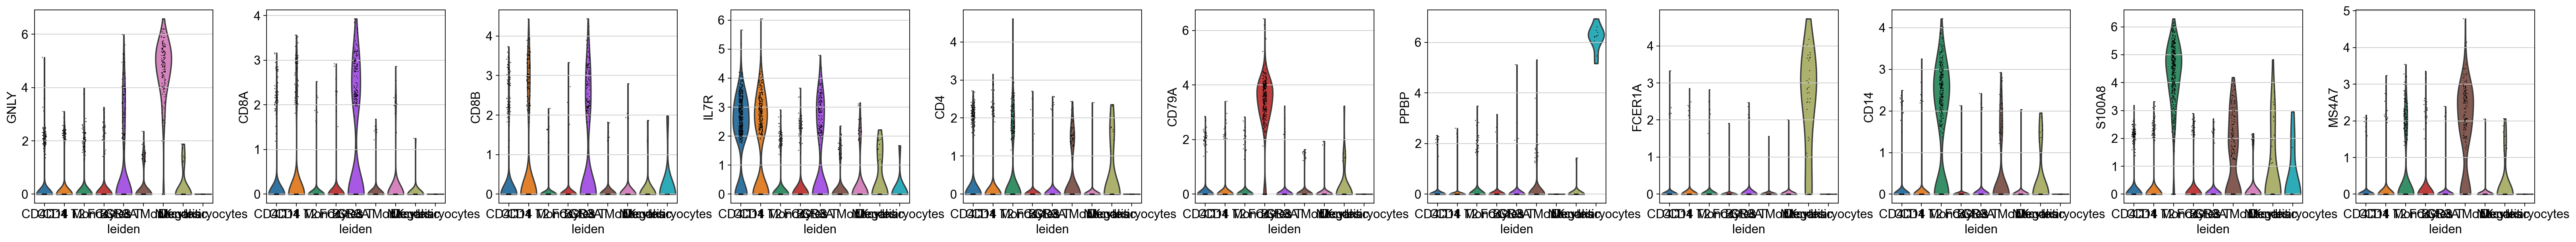

In [43]:
sc.pl.violin(adNorm, marker_genes, groupby='leiden')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns["dendrogram_['leiden']"]`


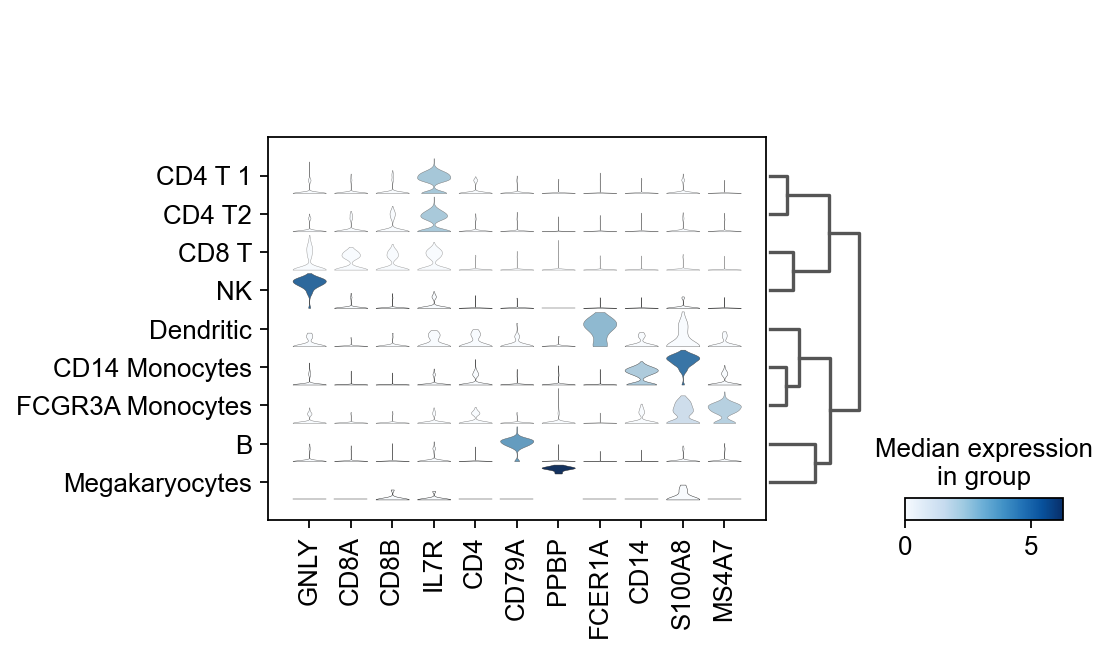

In [44]:
ax = sc.pl.stacked_violin(adNorm, marker_genes, groupby='leiden', swap_axes=False, dendrogram=True)

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


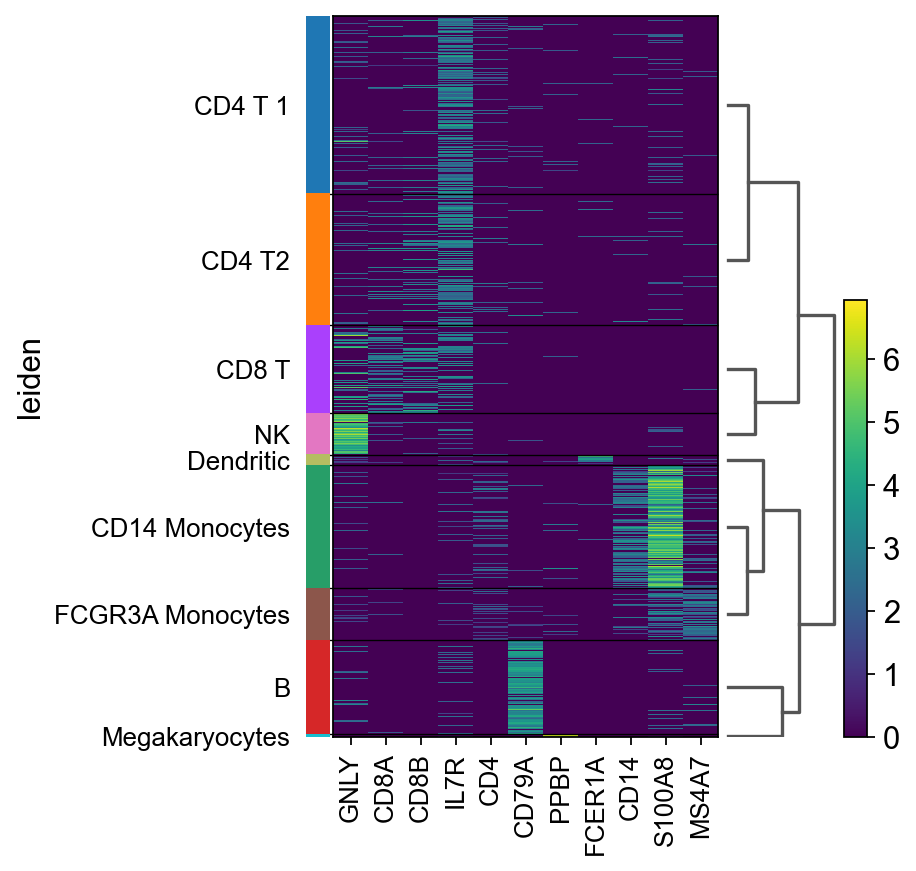

In [45]:
ax = sc.pl.heatmap(adNorm, marker_genes, groupby='leiden', cmap='viridis', dendrogram=True)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


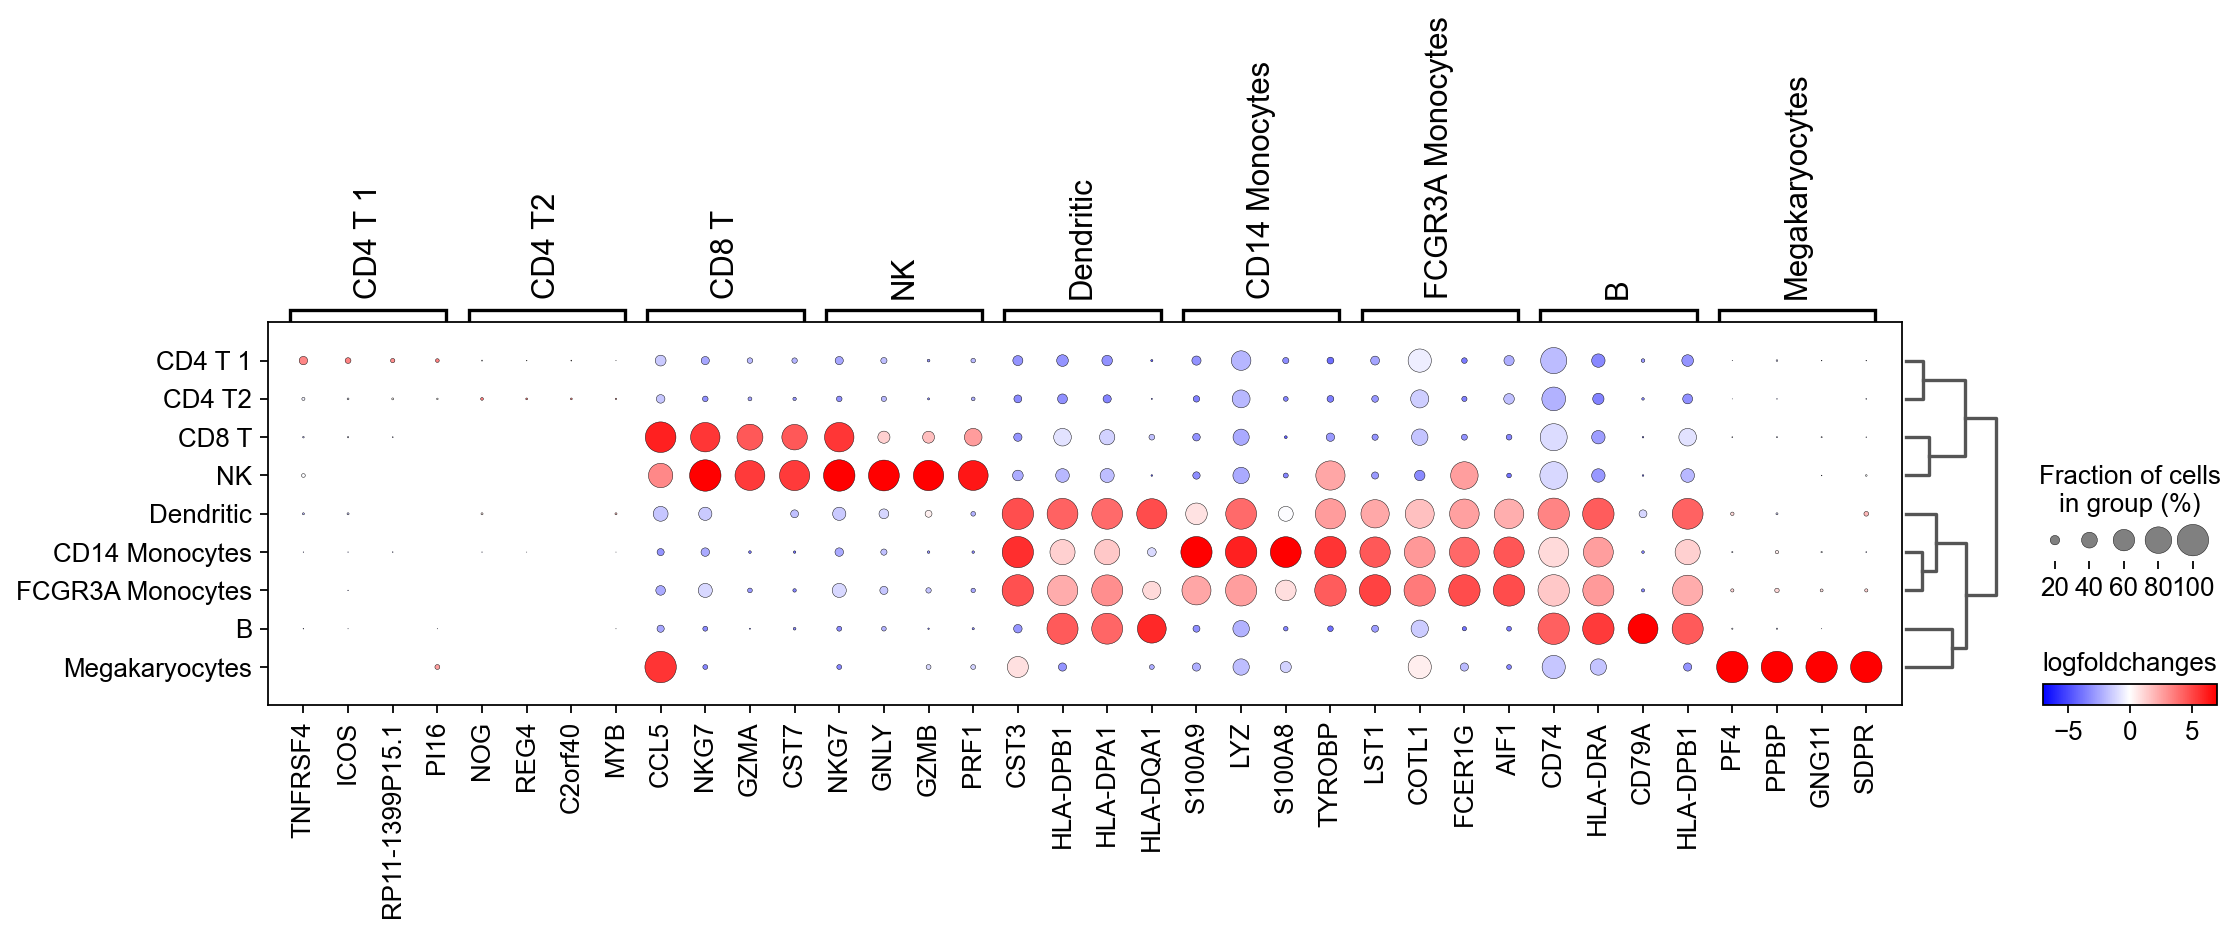

In [46]:
sc.tl.rank_genes_groups(adNorm,'leiden', n_genes=adNorm.shape[1], use_raw=True, method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adNorm, n_genes=4, values_to_plot='logfoldchanges', min_logfoldchange=3, vmax=7, vmin=-7, cmap='bwr')

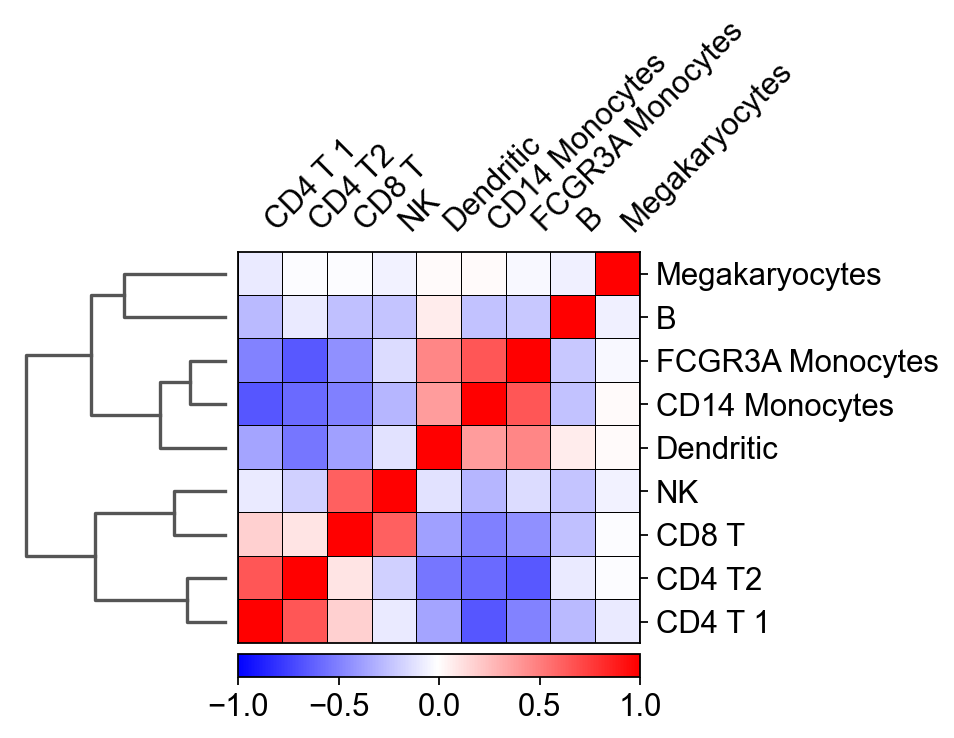

In [47]:
ax = sc.pl.correlation_matrix(adNorm, 'leiden', figsize=(5,3.5))

categories: CD4 T 1, CD4 T2, CD14 Monocytes, etc.
var_group_labels: NK


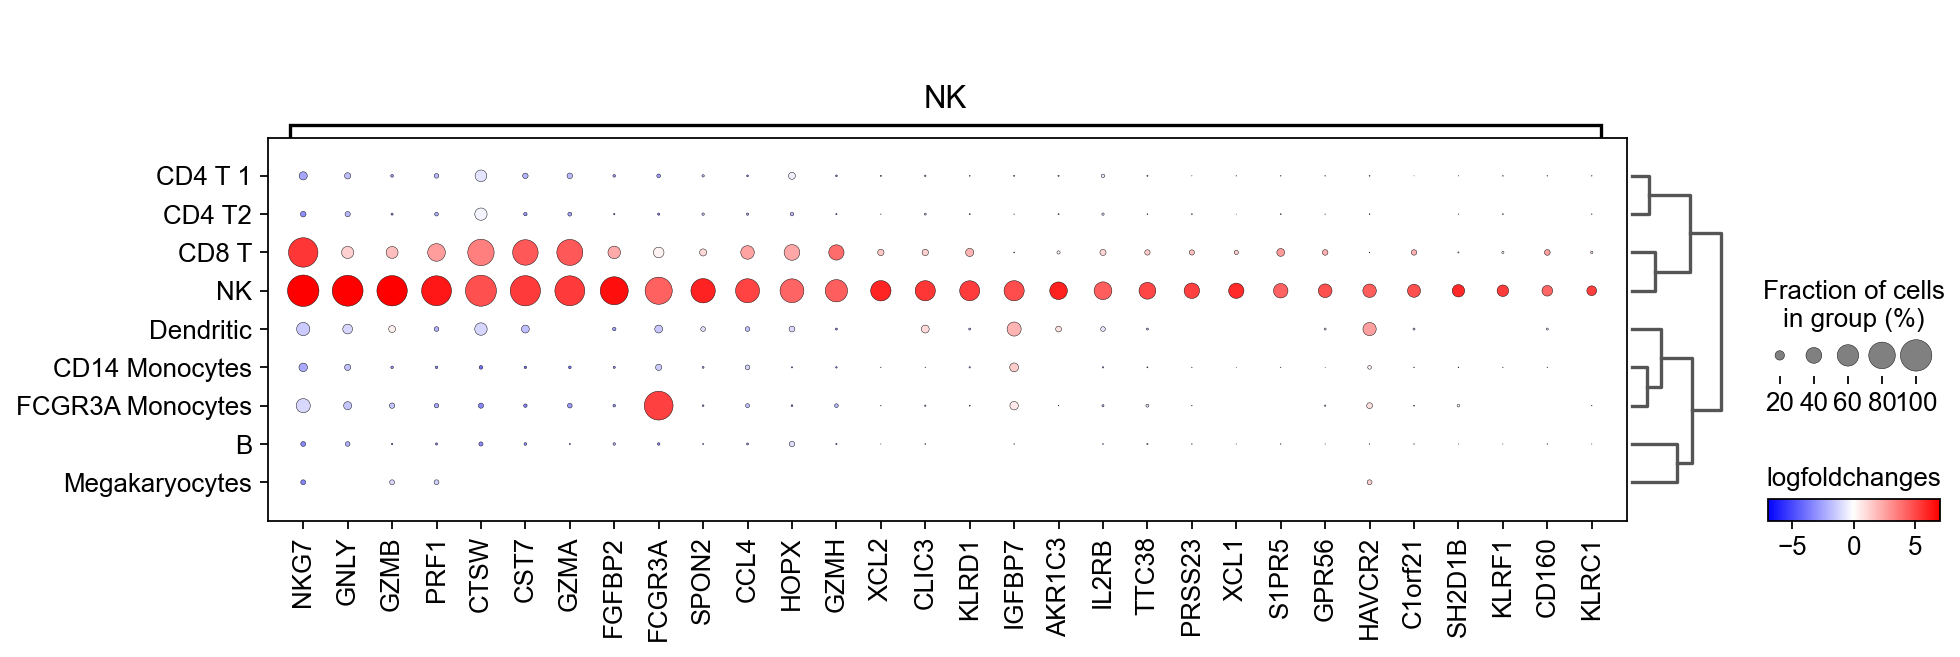

In [48]:
sc.pl.rank_genes_groups_dotplot(adNorm, n_genes=30, values_to_plot='logfoldchanges', min_logfoldchange=4, vmax=7, vmin=-7, cmap='bwr', groups=['NK'])

More visualizations here:https://scanpy-tutorials.readthedocs.io/en/latest/plotting/core.html

### What if we didn't QC?

In [49]:
adBad = adBase.copy()

# remove undetected genes
sc.pp.filter_genes(adBad, min_cells=5)

# normalize etc
sc.pp.normalize_per_cell(adBad, counts_per_cell_after=1e4)
sc.pp.log1p(adBad)

filtered out 20166 genes that are detected in less than 5 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


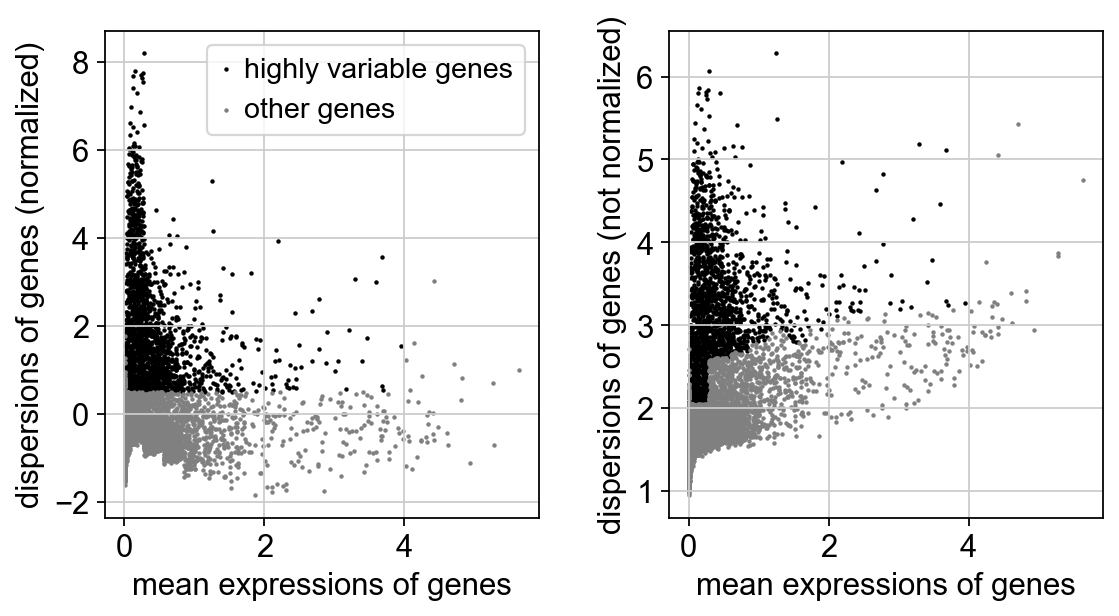

In [50]:
sc.pp.highly_variable_genes(adBad, min_mean=0.0125, max_mean=4, min_disp=0.5)
sc.pl.highly_variable_genes(adBad)

In [51]:
adBad.raw = adBad
sc.pp.scale(adBad, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [52]:
sc.tl.pca(adBad)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


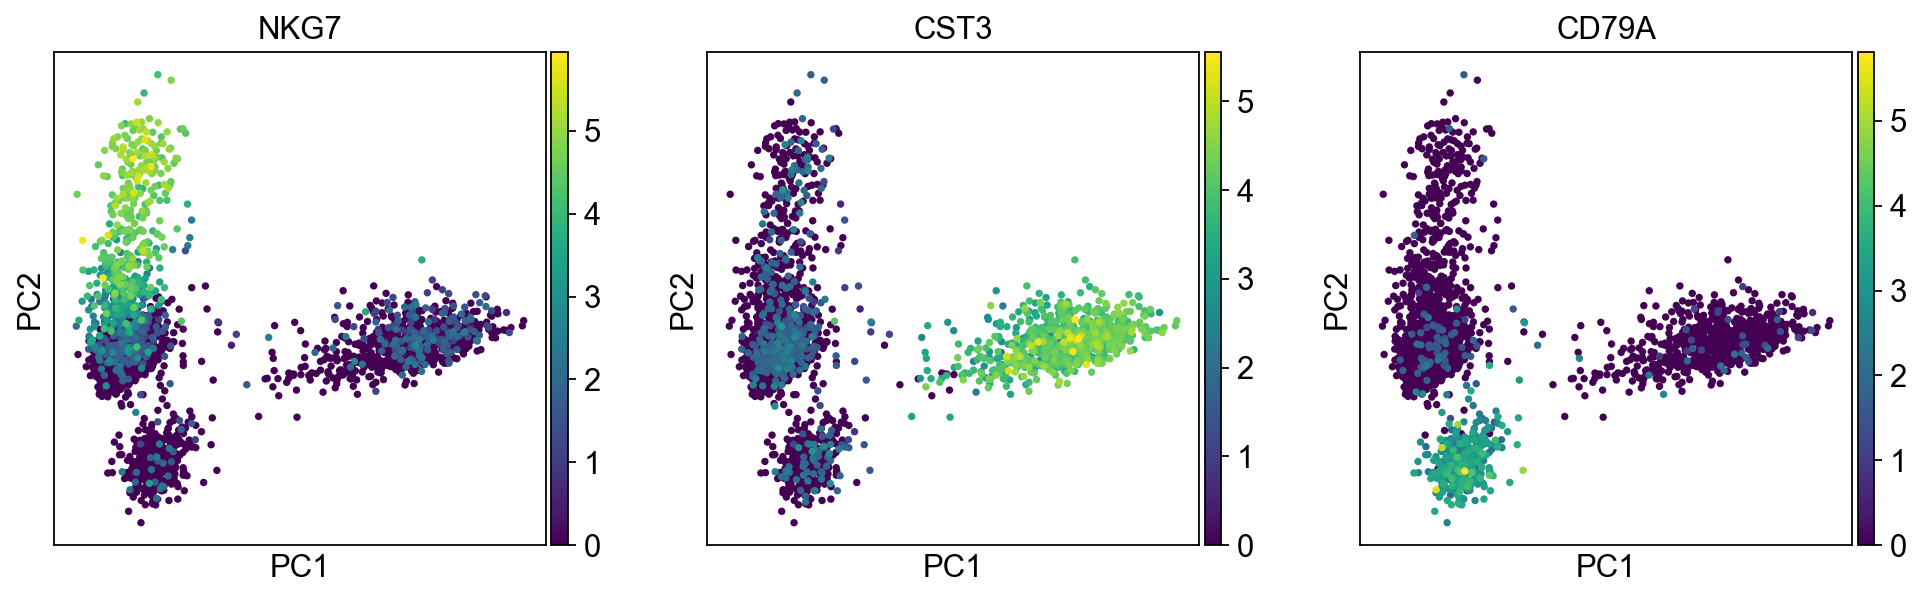

In [53]:
sc.pl.pca(adBad, color=['NKG7', 'CST3', 'CD79A'])

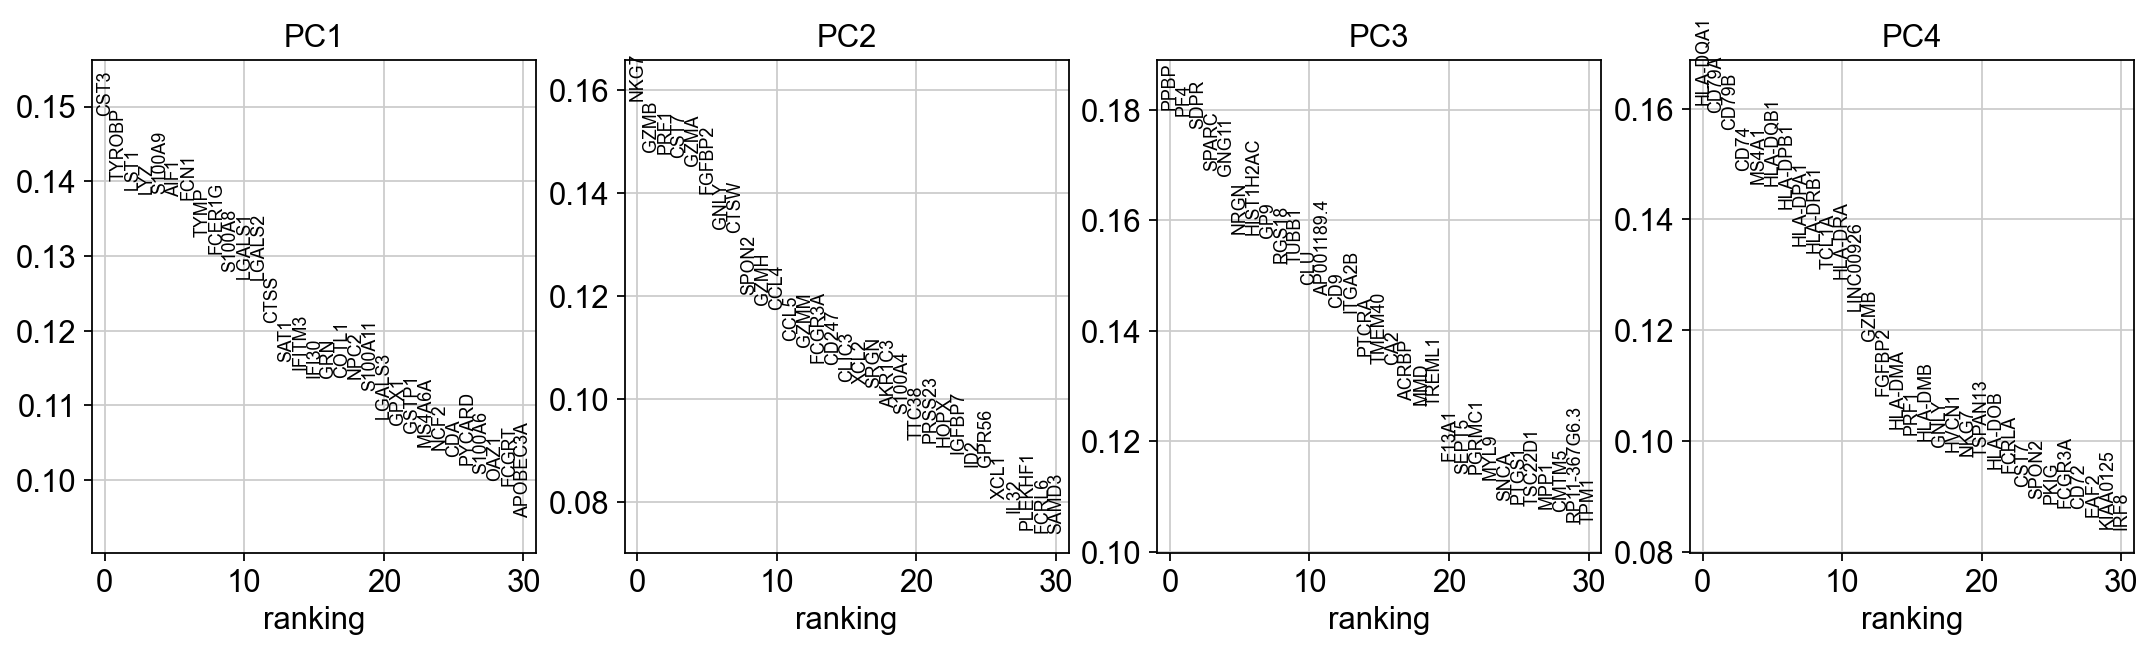

In [54]:
sc.pl.pca_loadings(adBad, components='1,2,3,4', include_lowest=False)

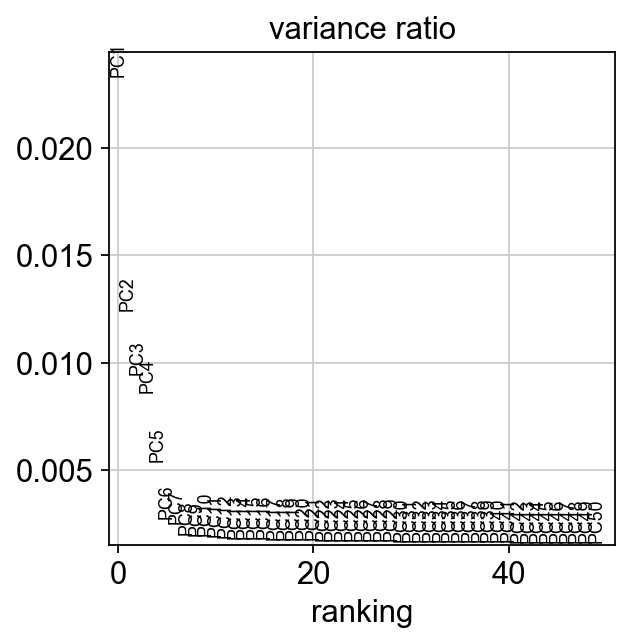

In [55]:
sc.pl.pca_variance_ratio(adBad, 50)

In [56]:
adBad

AnnData object with n_obs × n_vars = 2700 × 12572
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_counts'
    var: 'gene_ids', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [ ]:
npcs = 7
sc.pp.neighbors(adBad, n_neighbors=10, n_pcs=npcs)
sc.tl.umap(adBad, .5)
sc.tl.leiden(adBad, .4)
sc.pl.umap(adBad, color=['leiden', 'pct_counts_mt', 'total_counts'], alpha=.9, s=35, cmap='OrRd', legend_loc='on data')

computing neighbors
    using 'X_pca' with n_pcs = 7
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP


In [ ]:
nkgenes = adNorm.uns['rank_genes_groups']['names']['NK'][1:20]
nkgenes = nkgenes.tolist()
nkgenes

In [ ]:
sc.tl.score_genes(adNorm, nkgenes, score_name='nk_score')
bgenes = adNorm.uns['rank_genes_groups']['names']['B'][1:20]
bgenes = bgenes.tolist()
sc.tl.score_genes(adNorm, bgenes, score_name='b_score')
sc.pl.umap(adNorm, color=['leiden', 'nk_score', 'b_score'], alpha=.9, s=35, cmap='OrRd', legend_loc='on data')

To save results and re-load results

In [60]:
adNorm.write("adNorm_10x_PBMC.h5ad")
newAd = sc.read("adNorm_10x_PBMC.h5ad")
newAd

AnnData object with n_obs × n_vars = 2637 × 12390
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'leiden', 'nk_score', 'b_score'
    var: 'gene_ids', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: "dendrogram_['leiden']", 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'